### EduSpend CP#30: Global Higher-Education Cost Analytics & Planning
EDA Provided by Cursor

Findings:
- No missing values or duplicate rows  
- 907 entries, 12 columns
- 71 countries, UK, Australia, US and Canada represent over 36% of the entries
- Highs of Tuition, Rent & Insurance in USA, Cost of Living in Switzerland, Visa Fees in UK (Denmark has unusual spread)
- 556 cities, led by Singapore
- 622 universities, led by University of Washington
- 3 degree levels led by Masters
- 92 programs, with computer science a distant first with 34%
- Linear relationship between Rent, Living Cost, and Tuition
- Increasing # of outliers within Rent, Living Cost Index, Insurance, Visa Fee and Exchange Rate
- Total Cost of Attendance is Tuition (*total program*) + Visa Fee + (Insurance * years) + (Rent * 12 * years)
- TCA average of dataset is $52K, led by PhD $69K, USA $128K, Stanford $193, Machine Learning $158K


In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kaggle
import os
import warnings
from scipy import stats

%matplotlib inline
warnings.filterwarnings('ignore')

In [20]:
# Download the dataset
kaggle.api.dataset_download_files('adilshamim8/cost-of-international-education', path='../data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/adilshamim8/cost-of-international-education


In [21]:
df = pd.read_csv('../data/International_Education_Costs.csv')


In [22]:
# Basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nUnique Values:\n", df.nunique())
print("\nDuplicated Values:\n", df.duplicated().sum())
print("\nBasic Statistics:\n", df.describe())

Dataset Shape: (907, 12)

Columns: ['Country', 'City', 'University', 'Program', 'Level', 'Duration_Years', 'Tuition_USD', 'Living_Cost_Index', 'Rent_USD', 'Visa_Fee_USD', 'Insurance_USD', 'Exchange_Rate']

Data Types:
 Country               object
City                  object
University            object
Program               object
Level                 object
Duration_Years       float64
Tuition_USD            int64
Living_Cost_Index    float64
Rent_USD               int64
Visa_Fee_USD           int64
Insurance_USD          int64
Exchange_Rate        float64
dtype: object

Missing Values:
 Country               object
City                  object
University            object
Program               object
Level                 object
Duration_Years       float64
Tuition_USD            int64
Living_Cost_Index    float64
Rent_USD               int64
Visa_Fee_USD           int64
Insurance_USD          int64
Exchange_Rate        float64
dtype: object

Missing Values:
 Country              

no duplicate or missing values, but outliers on the max line, zero tuition, exchange rate standard deviation

Data Quality Assessment

In [23]:
# Check for outliers using Interquartile Range (IQR) method
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

# Apply to numerical columns
numerical_columns = df.select_dtypes(include=[np.number]).columns
for col in numerical_columns:
    outliers = detect_outliers(df, col)
    print(f"\nOutliers in {col}:", len(outliers))


Outliers in Duration_Years: 0

Outliers in Tuition_USD: 0

Outliers in Living_Cost_Index: 20

Outliers in Rent_USD: 3

Outliers in Visa_Fee_USD: 93

Outliers in Insurance_USD: 78

Outliers in Exchange_Rate: 169


Each country should have one exchange rate



In [24]:
# Find countries with multiple unique exchange rates and show those rates with their counts
multi_rate_countries = df.groupby('Country')['Exchange_Rate'].nunique()
multi_rate_countries = multi_rate_countries[multi_rate_countries > 1].index

# For each country, get a sorted list of (rate, count) tuples
print("\nCountries with multiple exchange rates and their counts:")
print("-" * 50)
for country in multi_rate_countries:
    rates_counts = df[df['Country'] == country]['Exchange_Rate'].value_counts().sort_index()
    rates_list = [(rate, count) for rate, count in rates_counts.items()]
    print(f"{country}: {rates_list}")


Countries with multiple exchange rates and their counts:
--------------------------------------------------
Argentina: [(275.0, 5), (821.5, 1)]
China: [(7.15, 10), (7.18, 2)]
Denmark: [(0.15, 3), (6.92, 2), (7.45, 10)]
India: [(82.75, 7), (83.2, 1)]
Indonesia: [(15600.0, 7), (15640.0, 1)]
Malaysia: [(4.65, 9), (4.72, 1)]
Mexico: [(17.05, 8), (17.2, 1)]
New Zealand: [(1.64, 1), (1.65, 8)]
Poland: [(4.02, 1), (4.1, 7)]
Russia: [(92.8, 1), (95.5, 8)]
Singapore: [(1.34, 12), (1.35, 6)]
South Korea: [(1300.0, 20), (1320.5, 3)]
Thailand: [(35.2, 1), (35.25, 7)]
Turkey: [(28.5, 8), (30.5, 1)]


In [25]:
# Replace exchange rates for countries with multiple rates with their most frequent value
for country in multi_rate_countries:
    most_freq_rate = df[df['Country'] == country]['Exchange_Rate'].mode()[0]
    df.loc[df['Country'] == country, 'Exchange_Rate'] = most_freq_rate
print("Exchange rates replaced with most frequent value for countries with multiple rates.")

Exchange rates replaced with most frequent value for countries with multiple rates.


Update cities with weighted average cost of living index

In [26]:
# Find (Country, City) pairs with multiple unique cost of living rates and show those rates with their counts
multi_rate_city_country = df.groupby(['Country', 'City'])['Living_Cost_Index'].nunique()
multi_rate_city_country = multi_rate_city_country[multi_rate_city_country > 1].index

# For each (Country, City), get a sorted list of (rate, count) tuples
print("\n(Country, City) pairs with multiple living cost rates and their counts:")
print("-" * 60)
for country, city in multi_rate_city_country:
    rates_counts = df[(df['Country'] == country) & (df['City'] == city)]['Living_Cost_Index'].value_counts().sort_index()
    rates_list = [(rate, count) for rate, count in rates_counts.items()]
    print(f"({country}, {city}): {rates_list}")


(Country, City) pairs with multiple living cost rates and their counts:
------------------------------------------------------------
(Argentina, Buenos Aires): [(42.5, 1), (42.6, 1)]
(Australia, Adelaide): [(64.5, 1), (67.5, 3), (68.5, 1)]
(Australia, Armidale): [(63.8, 3), (64.8, 1)]
(Australia, Brisbane): [(68.7, 1), (69.2, 6)]
(Australia, Canberra): [(68.9, 6), (69.8, 1), (70.2, 1)]
(Australia, Gold Coast): [(65.4, 1), (67.5, 1), (68.5, 3)]
(Australia, Hobart): [(62.1, 1), (64.5, 3), (65.4, 1)]
(Australia, Melbourne): [(71.2, 1), (72.4, 1), (72.8, 9)]
(Australia, Newcastle): [(63.2, 1), (66.2, 3), (66.8, 1)]
(Australia, Perth): [(67.2, 1), (68.2, 3), (69.8, 1)]
(Australia, Sydney): [(72.8, 1), (74.5, 9), (75.6, 1)]
(Australia, Townsville): [(65.2, 3), (65.8, 1)]
(Australia, Wollongong): [(63.4, 1), (65.8, 3), (67.2, 1)]
(Austria, Vienna): [(67.4, 1), (78.5, 1)]
(Belgium, Brussels): [(68.9, 1), (75.4, 1)]
(Brazil, Sao Paulo): [(48.5, 1), (55.8, 1)]
(Canada, Calgary): [(62.8, 2), (65

In [27]:
# Replace Living Cost Index for each (Country, City) pair with its weighted average
for country, city in multi_rate_city_country:
    subset = df[(df['Country'] == country) & (df['City'] == city)]
    # Calculate weighted average: value_counts gives weights
    value_counts = subset['Living_Cost_Index'].value_counts()
    values = value_counts.index.to_numpy()
    weights = value_counts.values
    weighted_avg = (values * weights).sum() / weights.sum()
    df.loc[(df['Country'] == country) & (df['City'] == city), 'Living_Cost_Index'] = weighted_avg
print("Living Cost Index replaced with weighted average for (Country, City) pairs with multiple rates.")

Living Cost Index replaced with weighted average for (Country, City) pairs with multiple rates.


Univariate Analysis

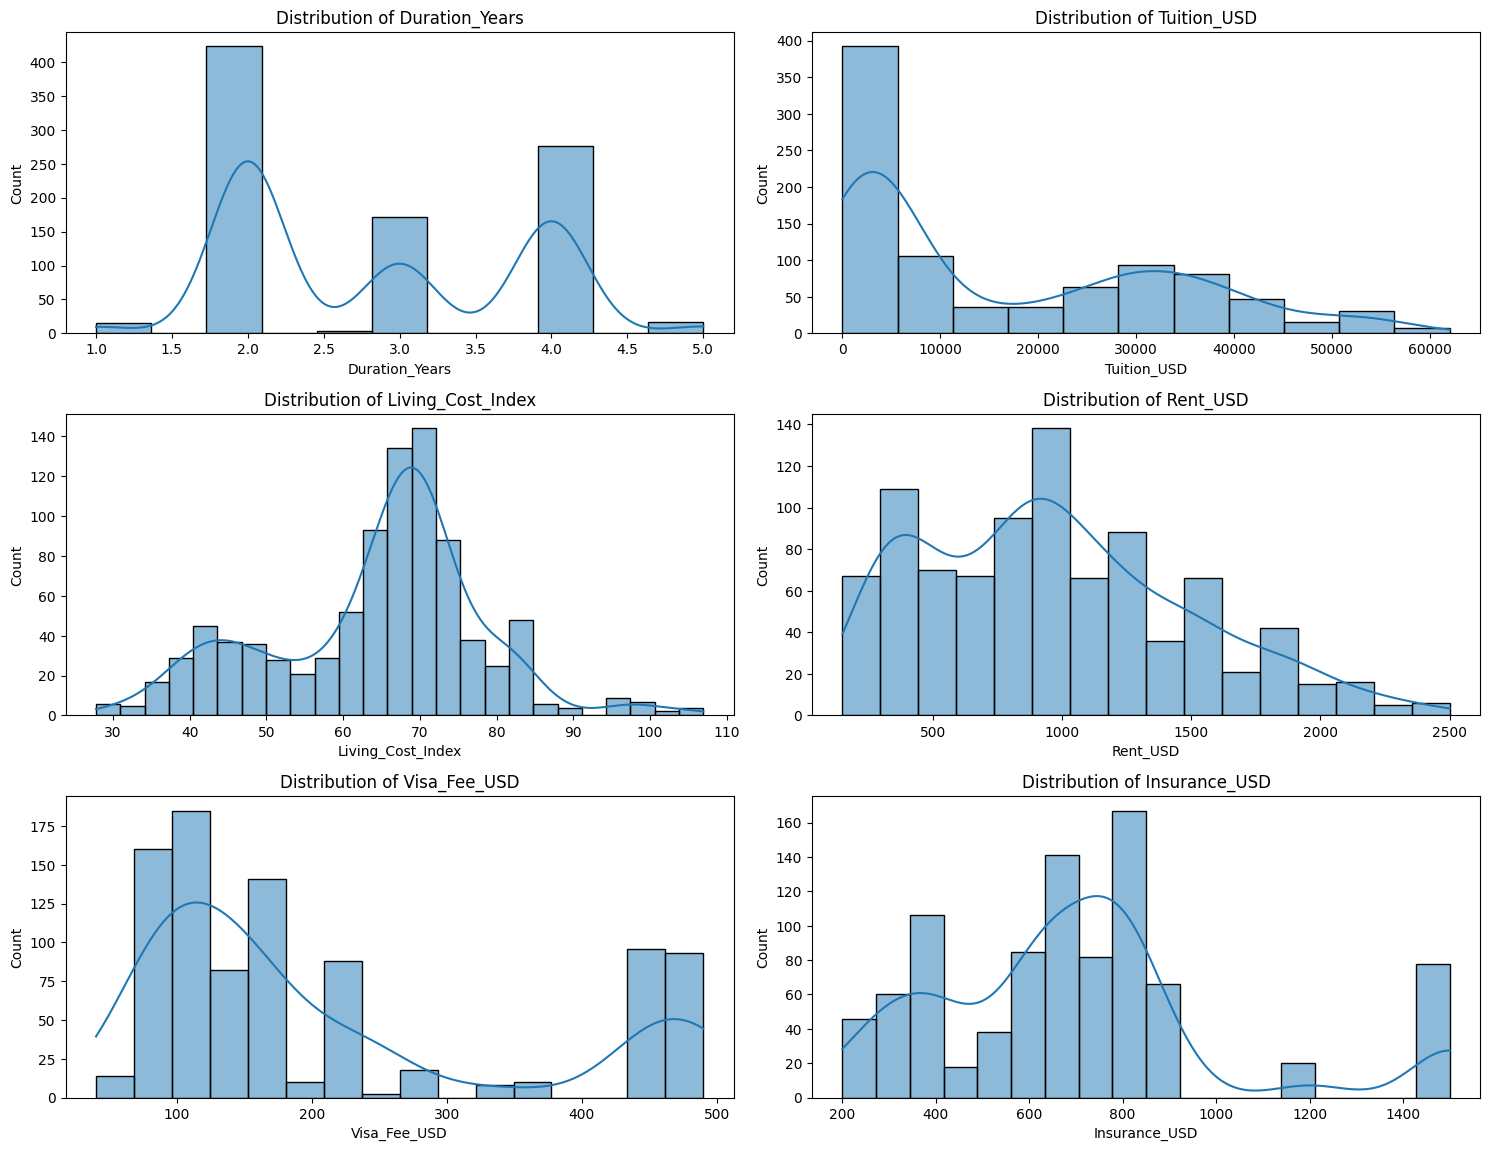

In [28]:
# Distribution of numerical variables
plt.figure(figsize=(15, 15))
for i, col in enumerate(numerical_columns[:-1], 1):  # Exclude the last column (Exchange Rate)
    plt.subplot(4, 2, i)
    sns.histplot(data=df, x=col, kde=True)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.show()

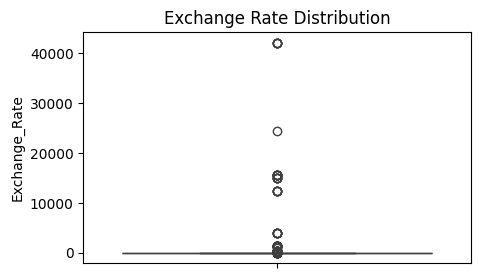

In [29]:
# Distribution of Exchange Rate using boxplot due to outliers
plt.figure(figsize=(5, 3))
sns.boxplot(data=df, y='Exchange_Rate')
plt.title('Exchange Rate Distribution')
plt.show()

Filtered Data Statistics:
count     883.00
mean       76.94
std       384.24
min         0.31
25%         0.92
50%         1.35
75%         4.65
max      3950.00
Name: Exchange_Rate, dtype: float64


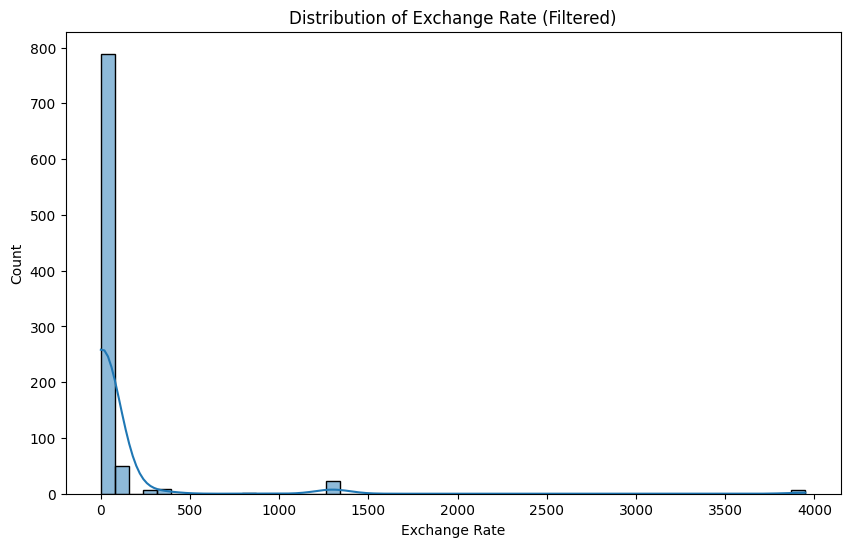

In [30]:
# Distribution of Exchange Rate excluding outliers
plt.figure(figsize=(10, 6))

# Filter data to remove extreme values (keep values within 3 standard deviations)
filtered_data = df[df['Exchange_Rate'].between(
    df['Exchange_Rate'].mean() - 3*df['Exchange_Rate'].std(),
    df['Exchange_Rate'].mean() + 3*df['Exchange_Rate'].std()
)]

# Create the histogram with specific bin size
sns.histplot(data=filtered_data, x='Exchange_Rate', kde=True, bins=50)

# Add a title and labels
plt.title('Distribution of Exchange Rate (Filtered)')
plt.xlabel('Exchange Rate')
plt.ylabel('Count')

# Print some statistics about the filtered data
print("Filtered Data Statistics:")
print(filtered_data['Exchange_Rate'].describe().round(2))

plt.show()


Value counts for Country:
Country
UK                93
Australia         86
USA               78
Canada            76
Germany           33
                  ..
Czech Republic     1
Hong Kong          1
Israel             1
Nigeria            1
Vietnam            1
Name: count, Length: 71, dtype: int64


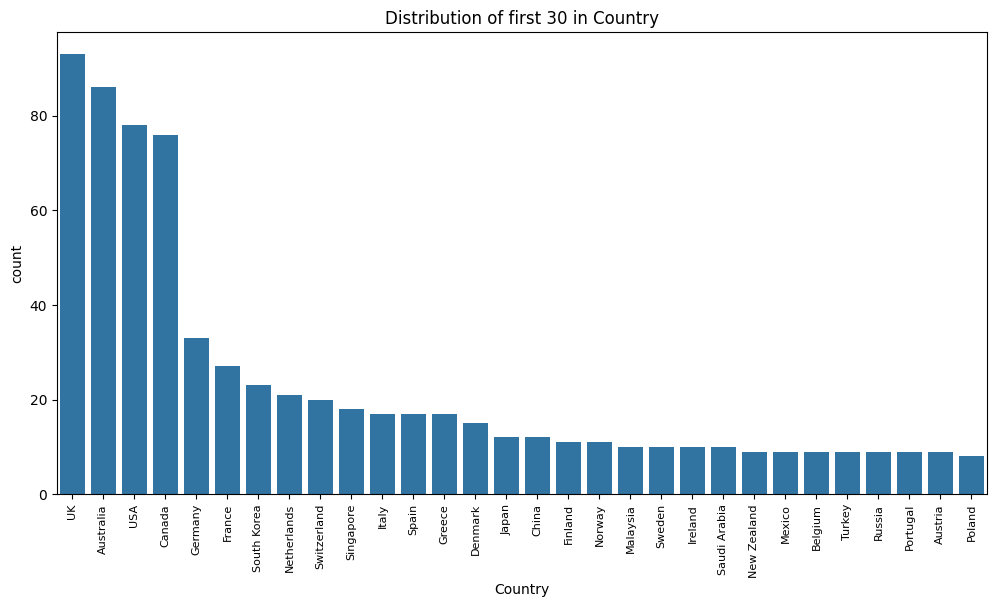


Value counts for City:
City
Singapore      18
Sydney         11
Melbourne      11
London         10
Canberra        8
               ..
Penang          1
Santa Tecla     1
Andijan         1
Tabriz          1
Subotica        1
Name: count, Length: 556, dtype: int64


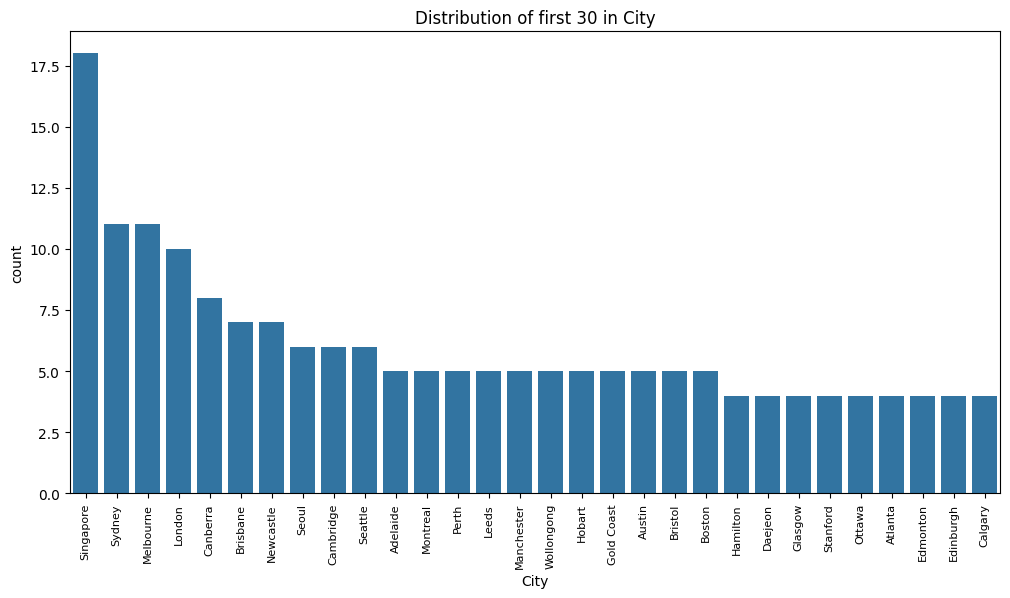


Value counts for University:
University
University of Washington           6
Stanford University                5
Australian National University     5
University of Tasmania             5
University of Western Australia    5
                                  ..
USM                                1
Universidad Politecnica            1
Imperial College                   1
ITCA-FEPADE                        1
Andijan State University           1
Name: count, Length: 622, dtype: int64


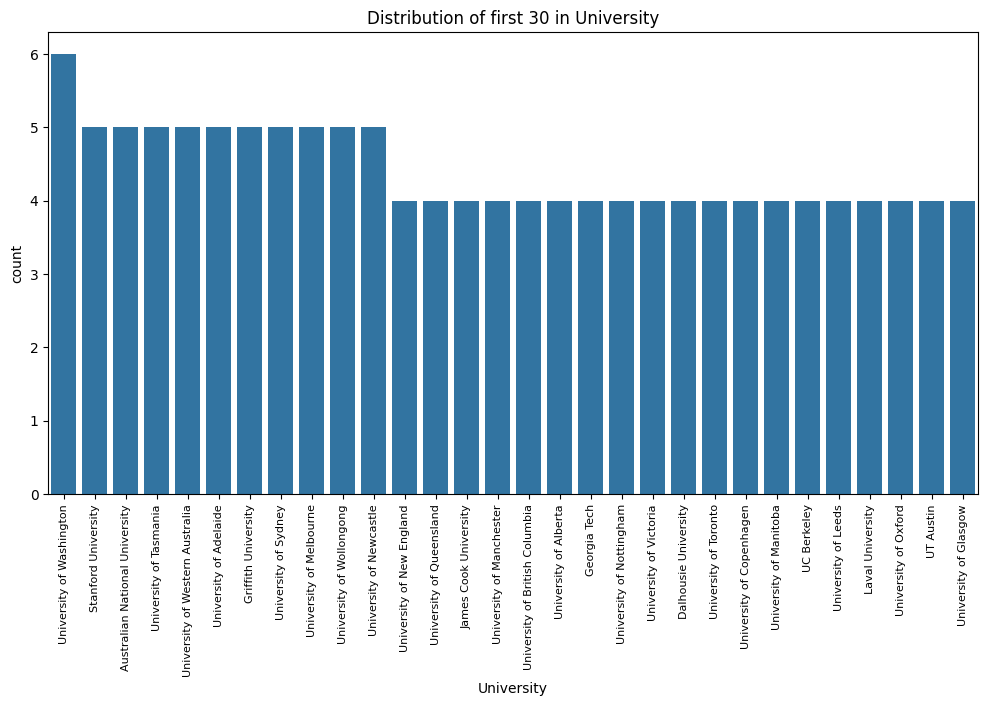


Value counts for Program:
Program
Computer Science           312
Data Science                82
Computer Engineering        71
Software Engineering        57
Artificial Intelligence     53
                          ... 
Electronics                  1
Electronic Engineering       1
Digital Design               1
Digital Business             1
Data Systems                 1
Name: count, Length: 92, dtype: int64


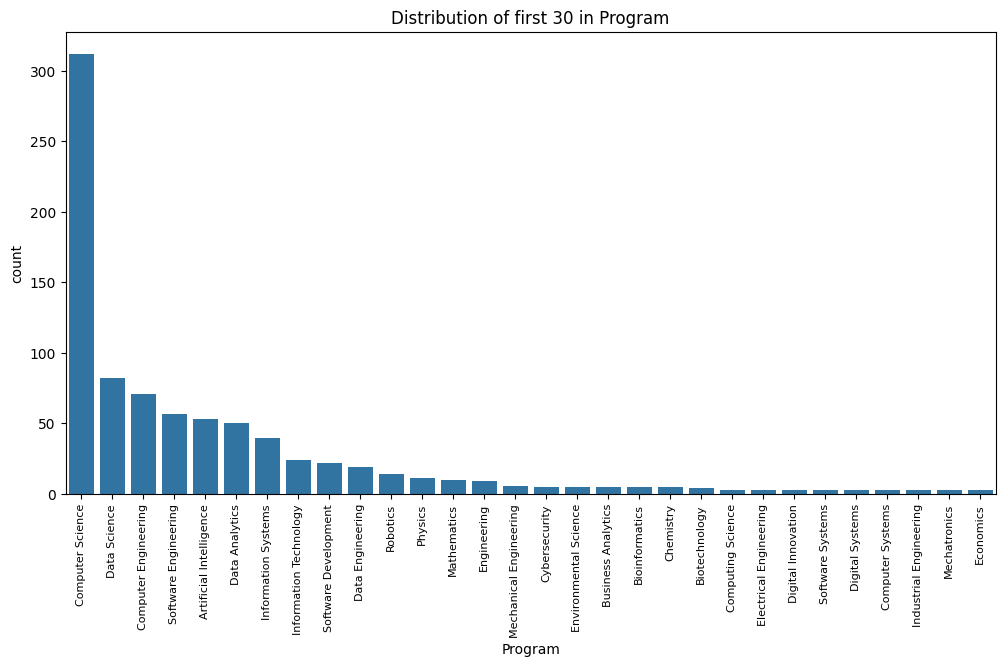


Value counts for Level:
Level
Master      451
Bachelor    297
PhD         159
Name: count, dtype: int64


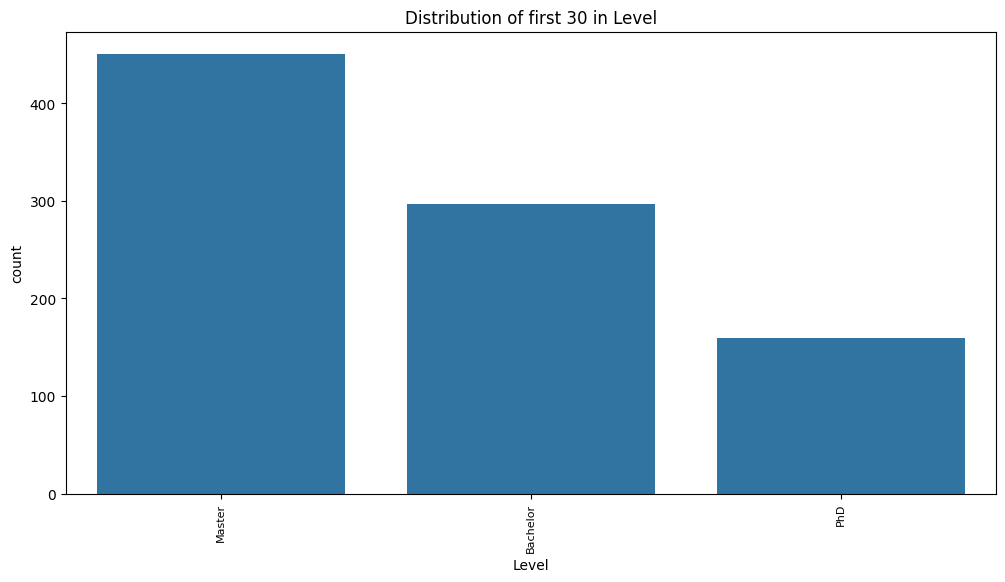

In [31]:
# Categorical variables analysis
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    print(f"\nValue counts for {col}:")
    value_counts = df[col].value_counts().head(30)
    print(df[col].value_counts())
    plt.figure(figsize=(12, 6))
    sns.countplot(data=df, x=col, order=value_counts.index)
    plt.xticks(rotation=90, fontsize=8)
    plt.title(f'Distribution of first 30 in {col}')
    plt.show()

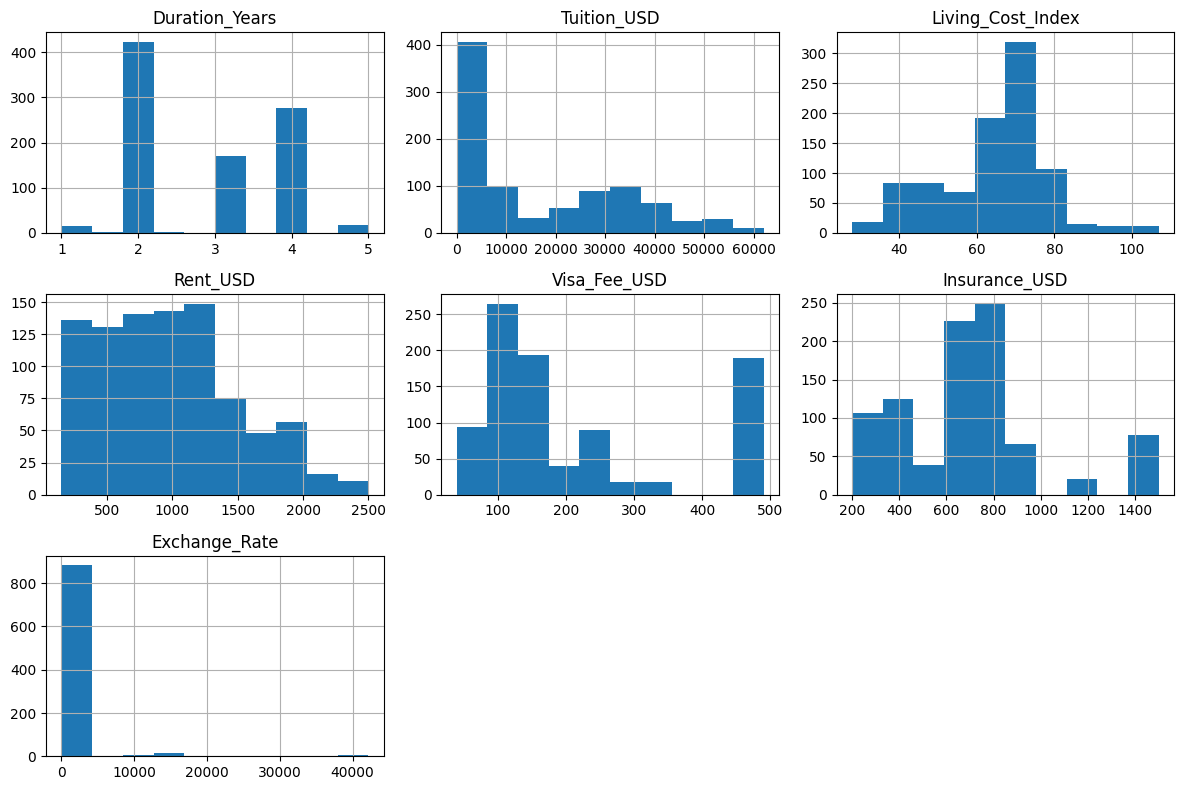

In [32]:
# Histograms for numerical columns
df.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

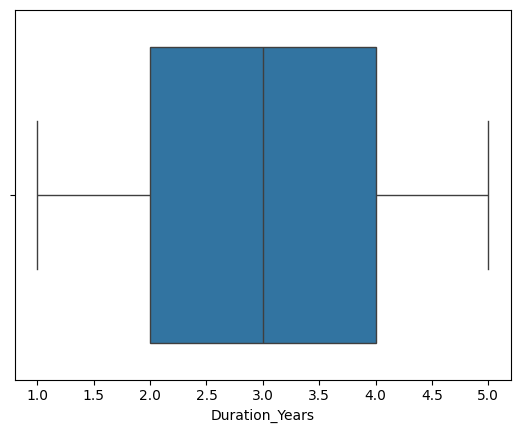

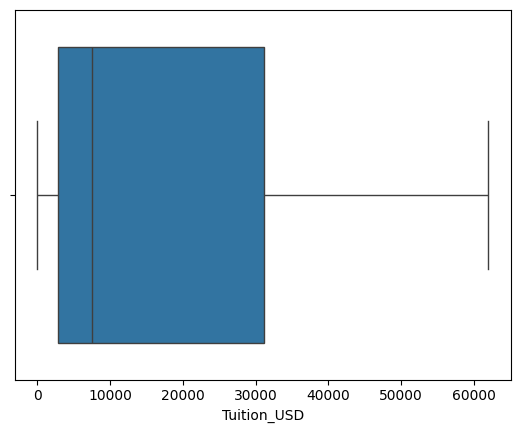

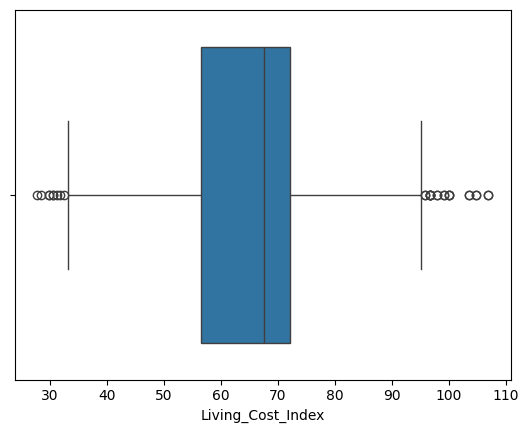

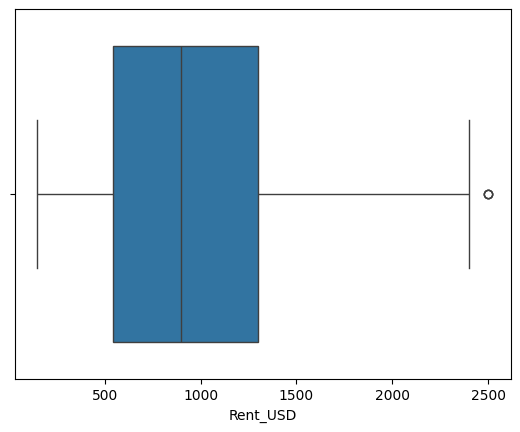

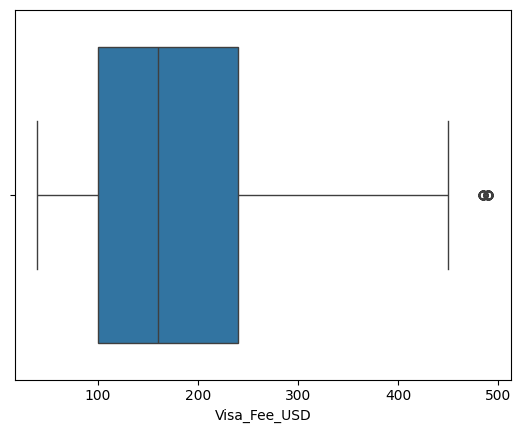

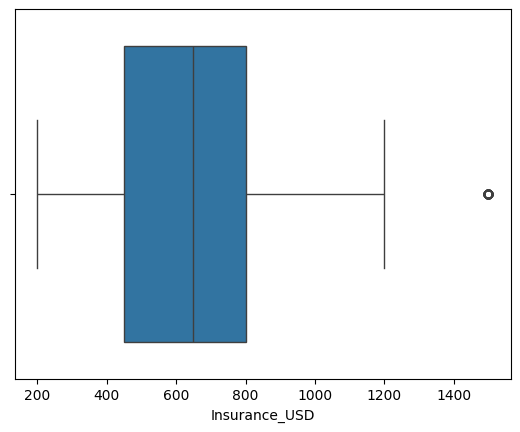

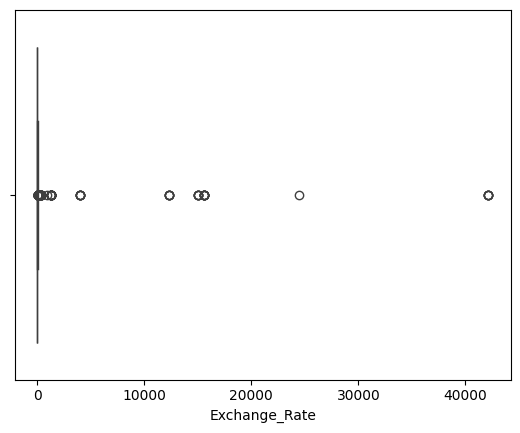

In [33]:
# Box plots for numerical columns
for col in df.select_dtypes(include=np.number).columns:
    sns.boxplot(x=df[col])
    plt.show()

Bivariate Analysis

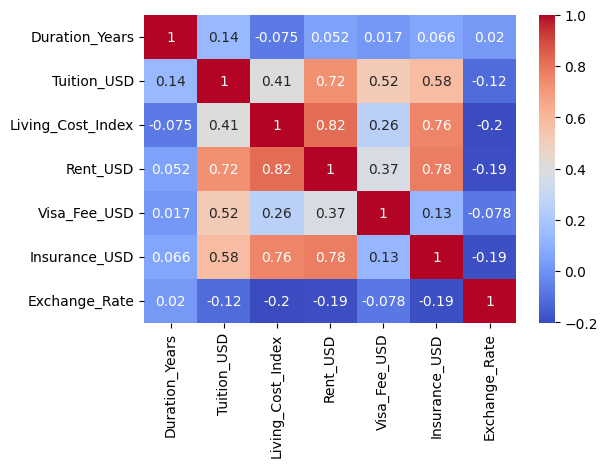

In [34]:
# Correlation analysis
plt.figure(figsize=(6,4))
numeric_df = df.select_dtypes(include=np.number)
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.show()

strong correlations between Rent & Living Cost & Insurance, as well as Rent & Tuition 

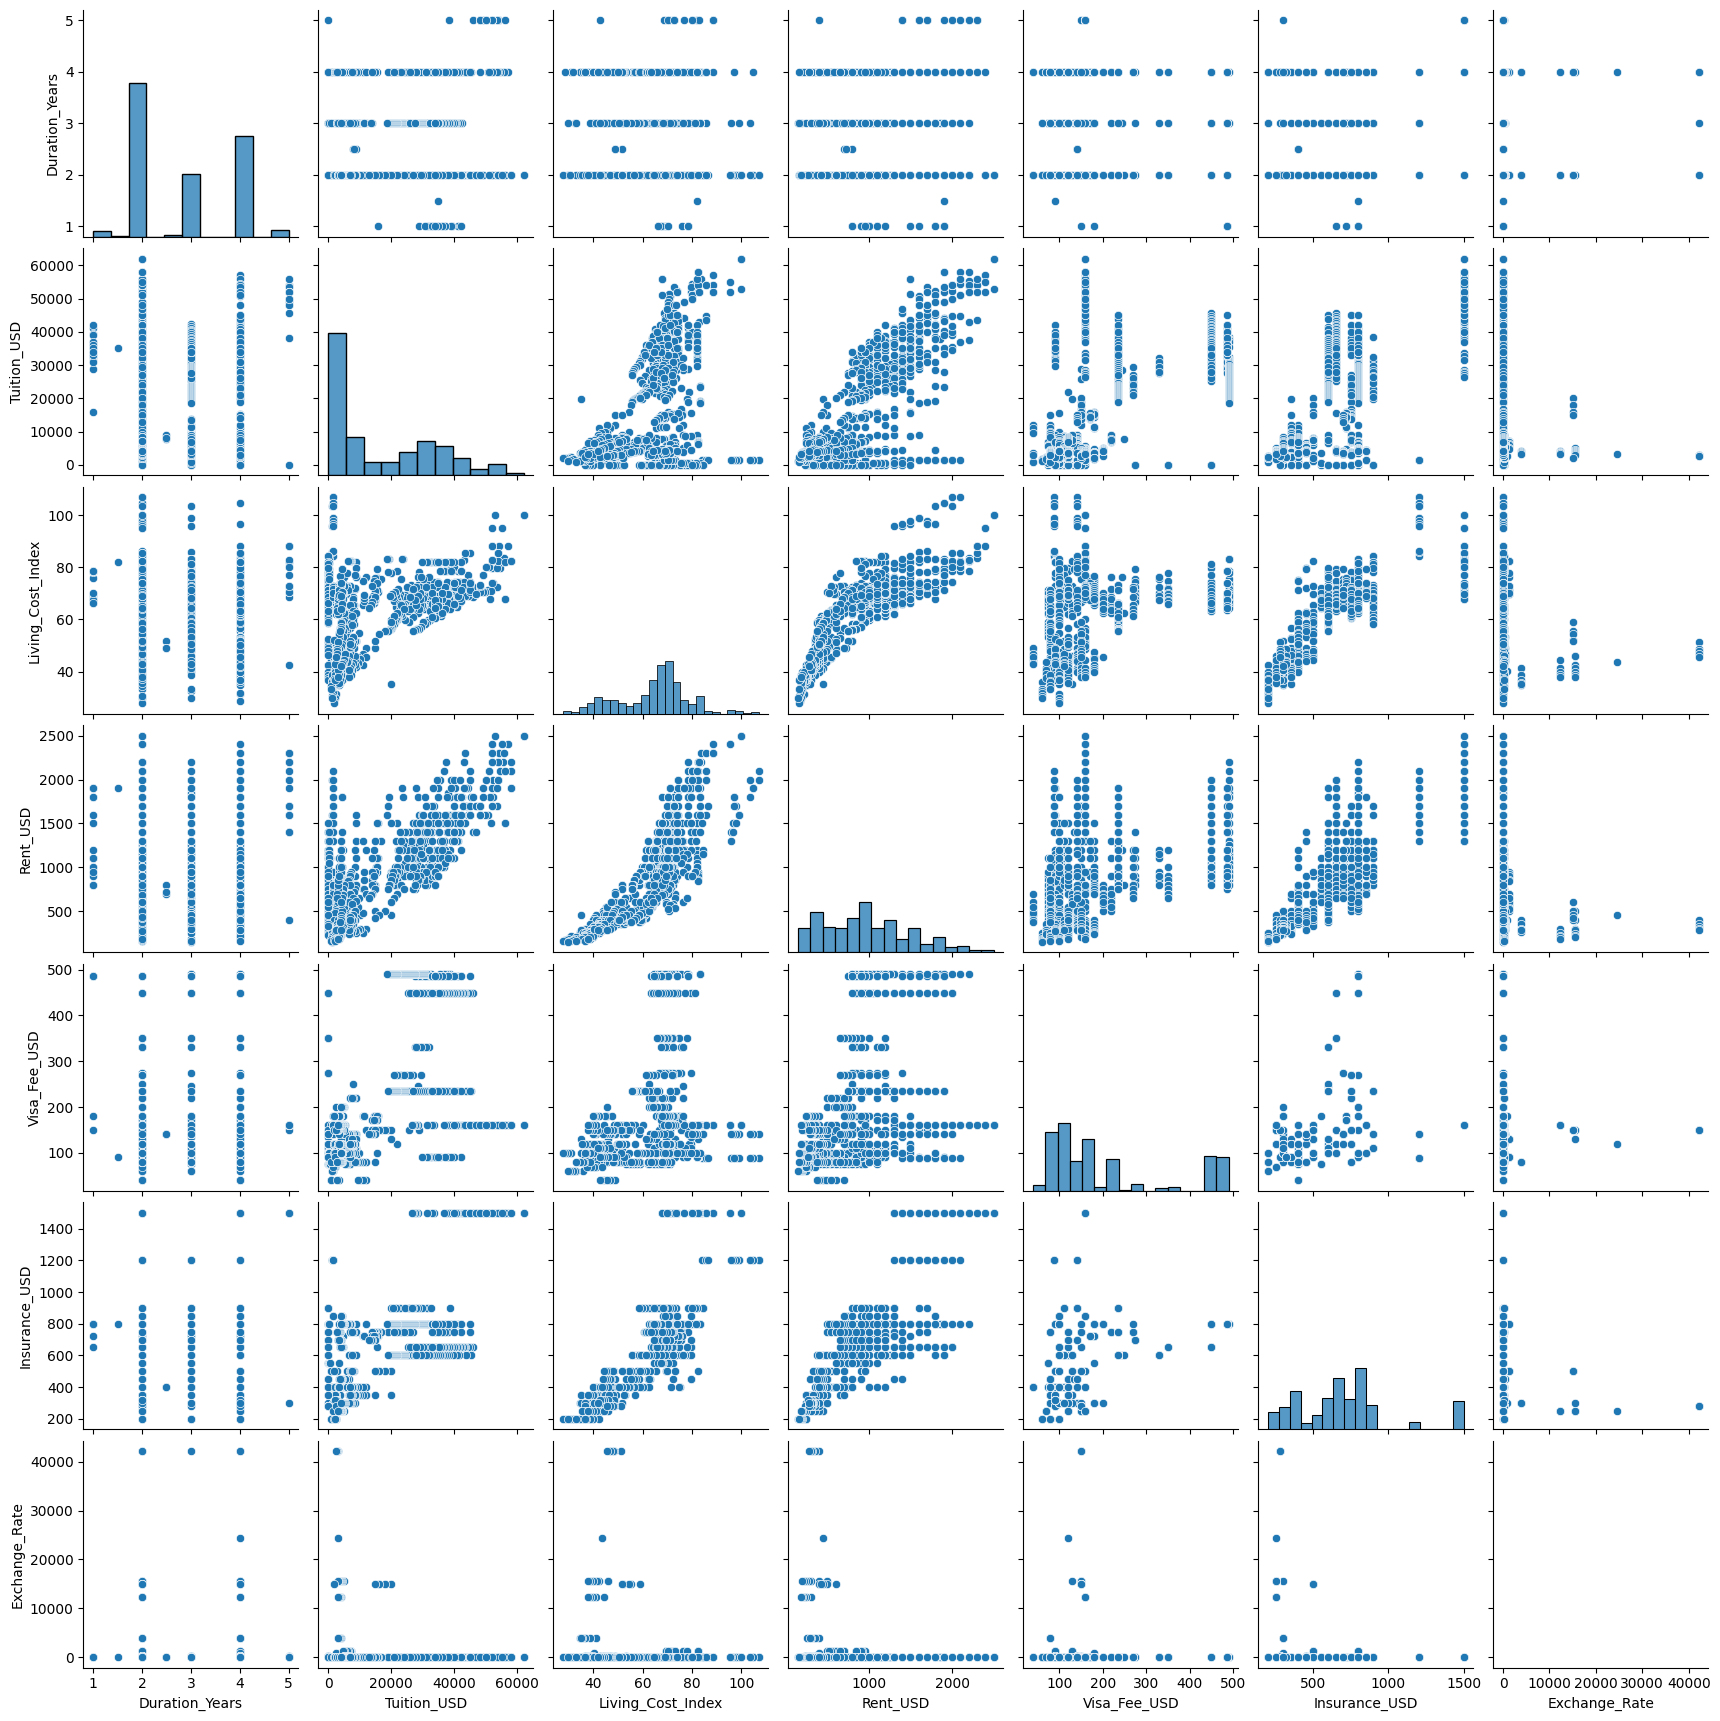

In [35]:
# Scatter plots for key numerical variables
sns.pairplot(df[numerical_columns])
plt.show()



Value counts for Country:
Country
UK                93
Australia         86
USA               78
Canada            76
Germany           33
                  ..
Czech Republic     1
Hong Kong          1
Israel             1
Nigeria            1
Vietnam            1
Name: count, Length: 71, dtype: int64


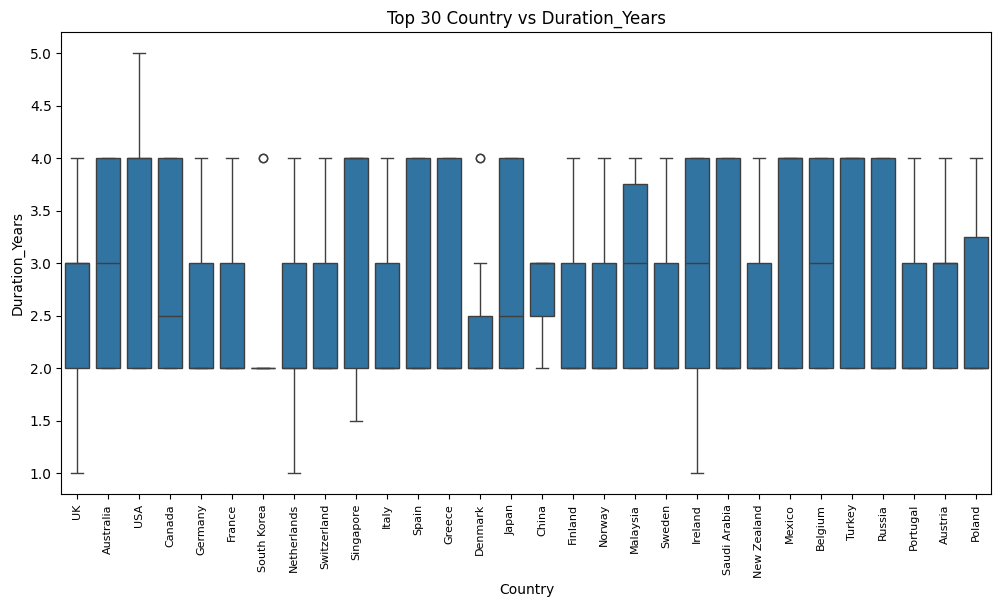

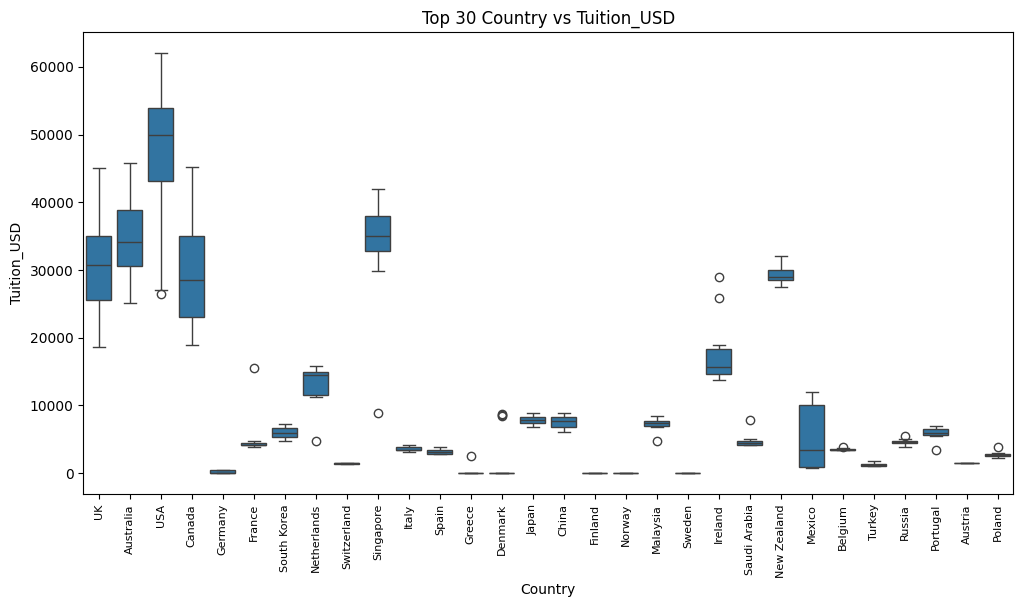

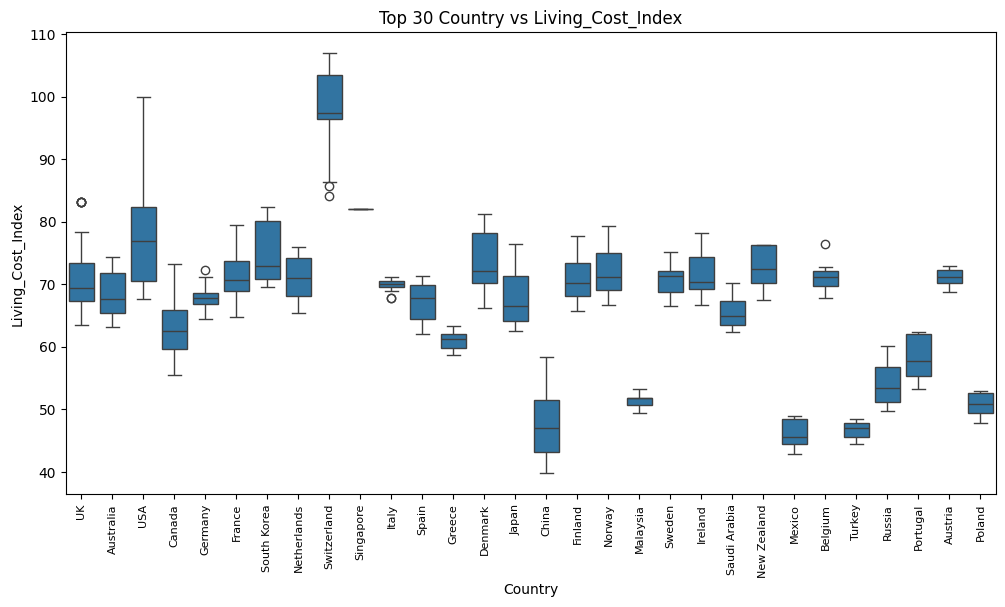

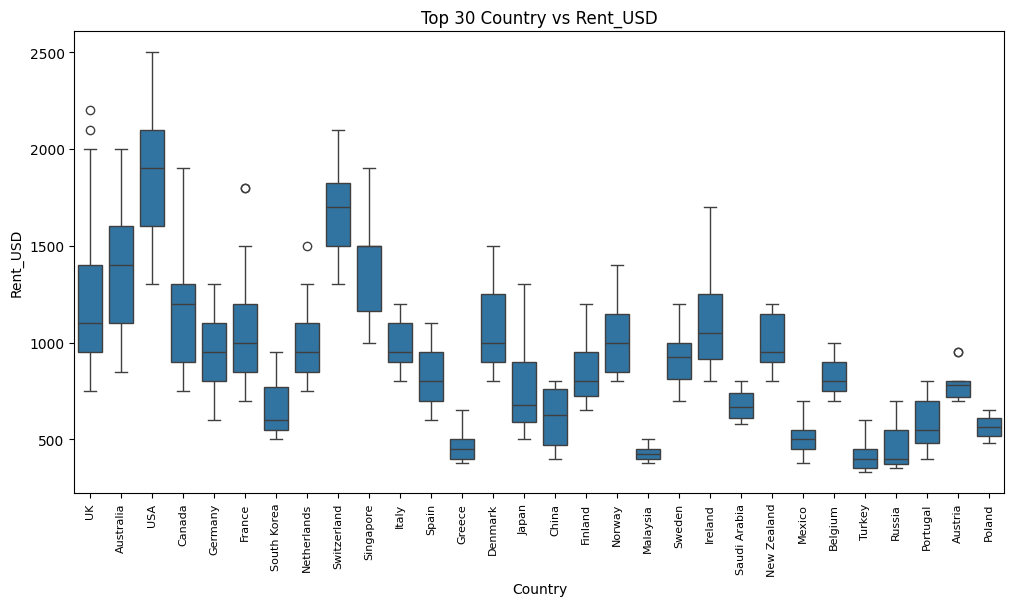

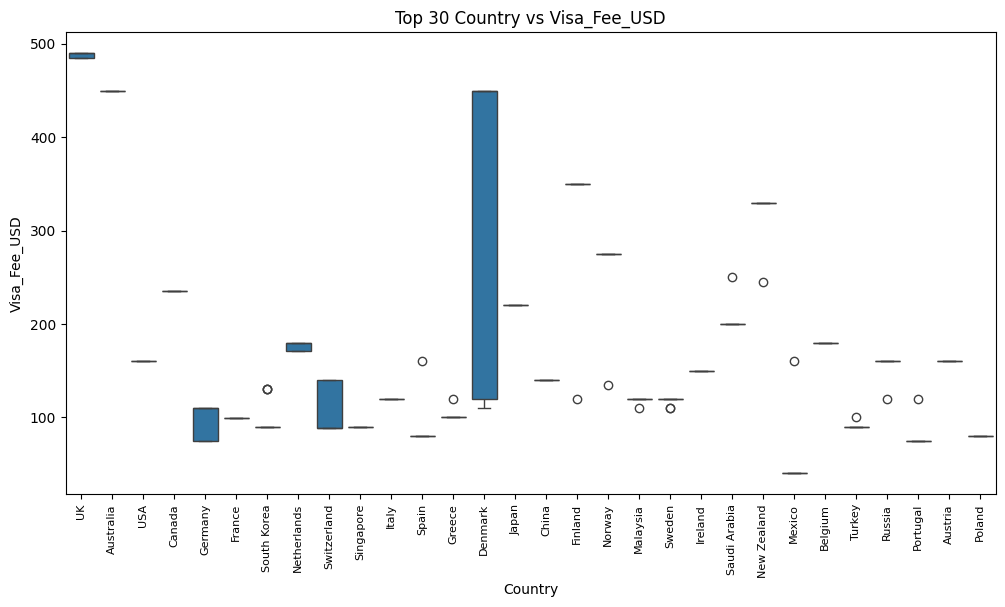

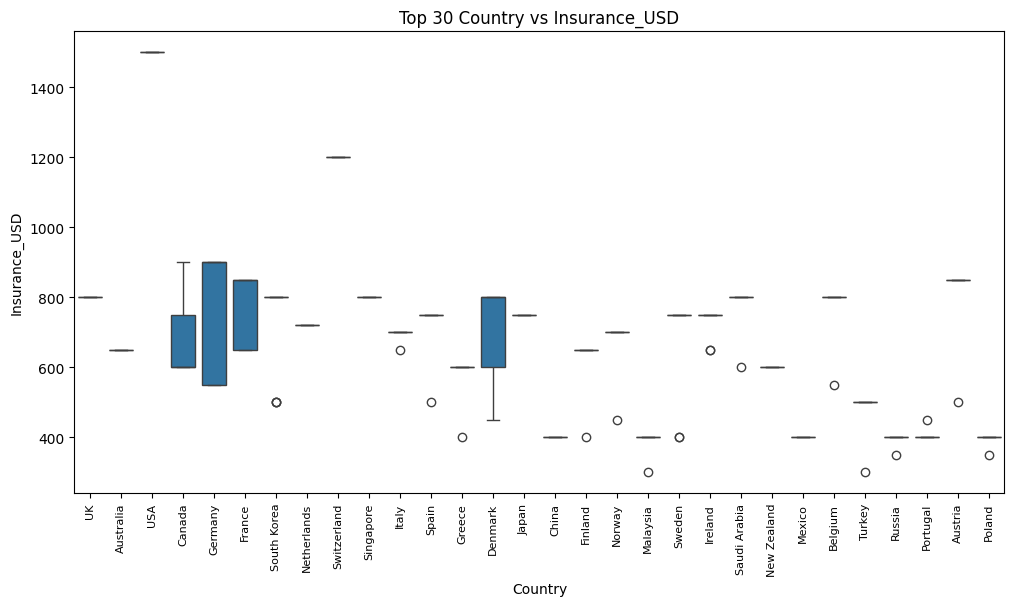

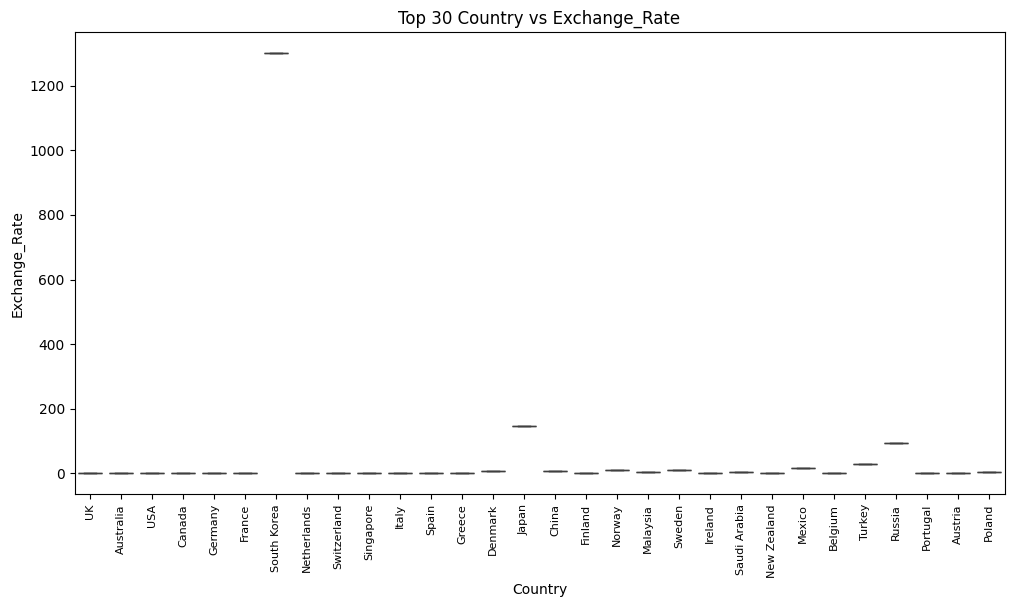


Value counts for City:
City
Singapore      18
Sydney         11
Melbourne      11
London         10
Canberra        8
               ..
Penang          1
Santa Tecla     1
Andijan         1
Tabriz          1
Subotica        1
Name: count, Length: 556, dtype: int64


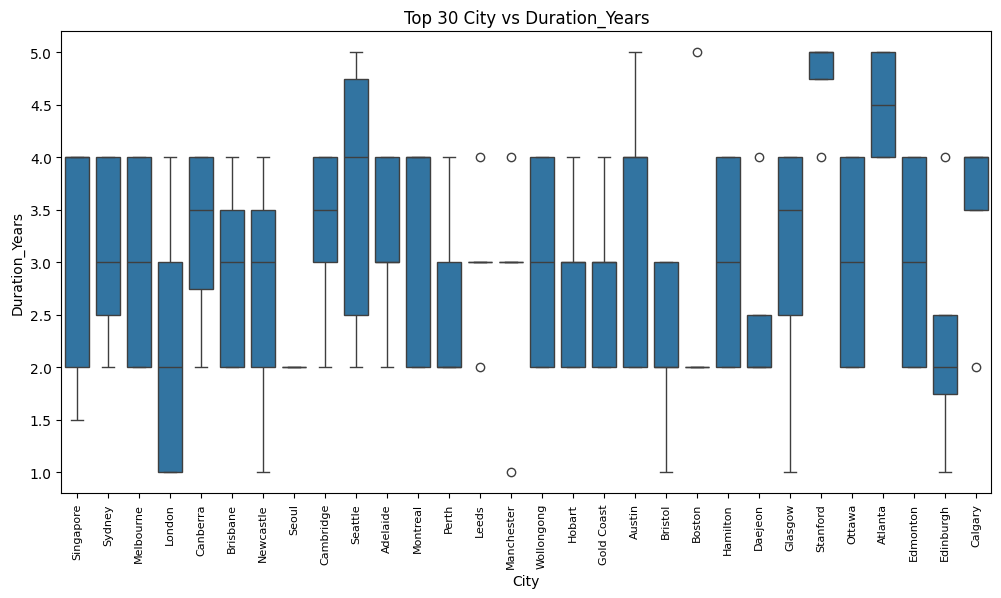

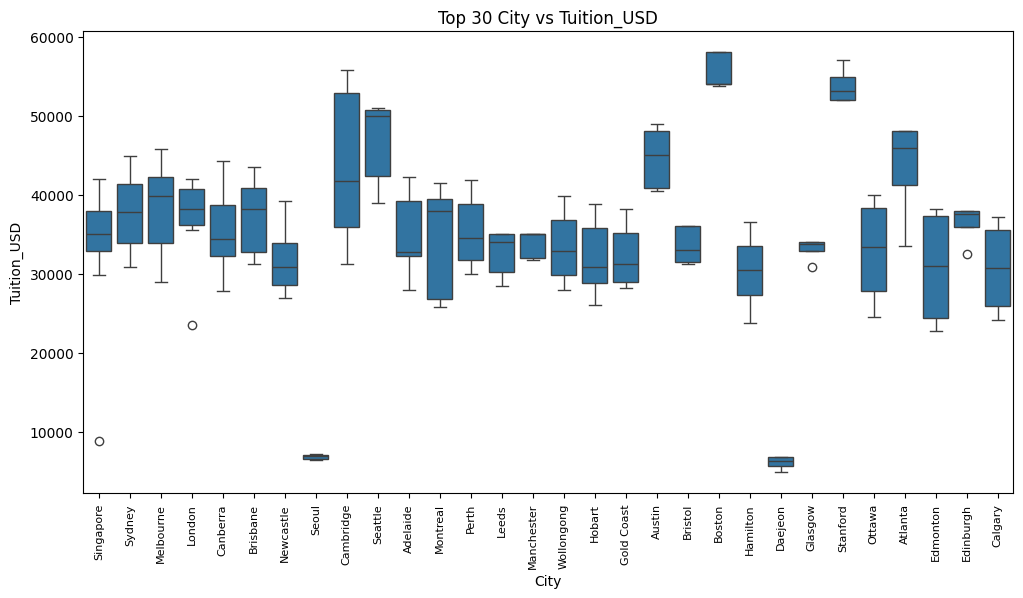

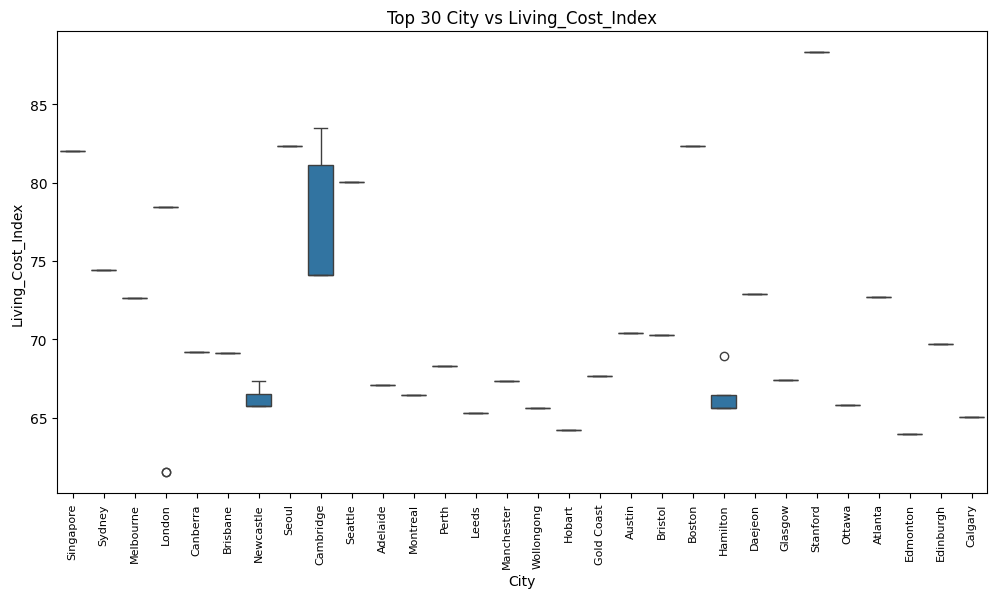

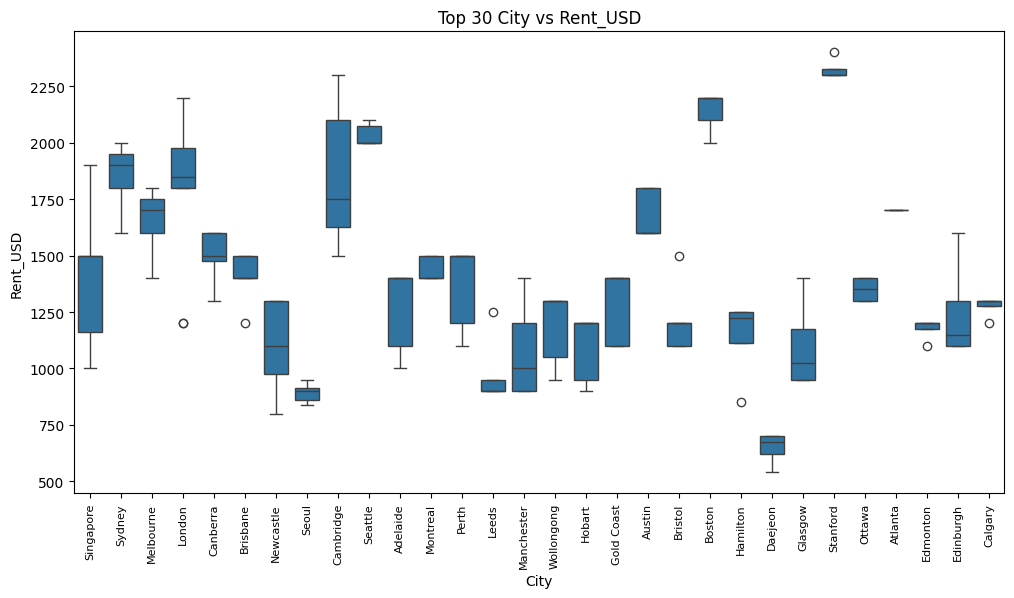

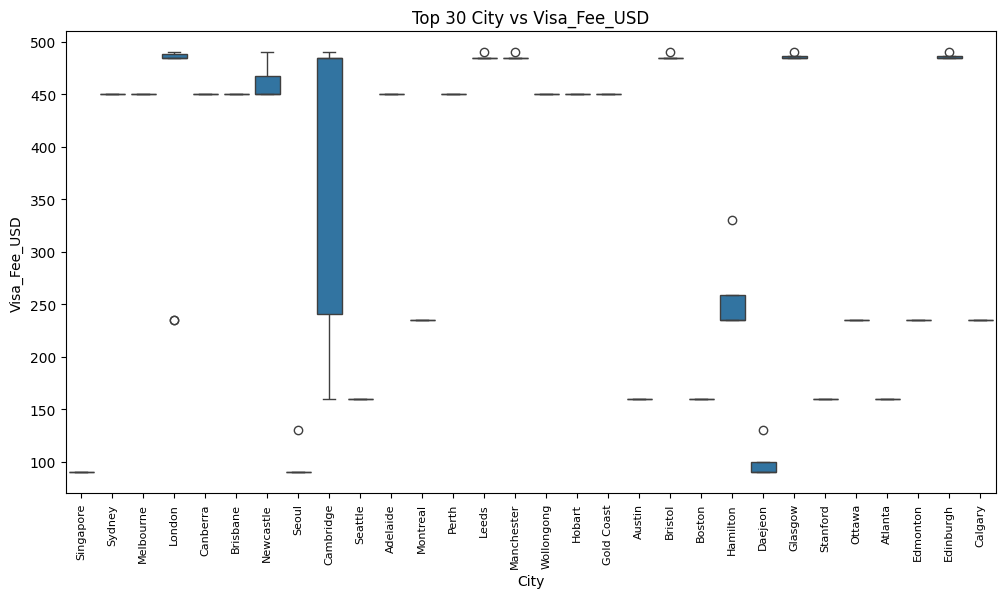

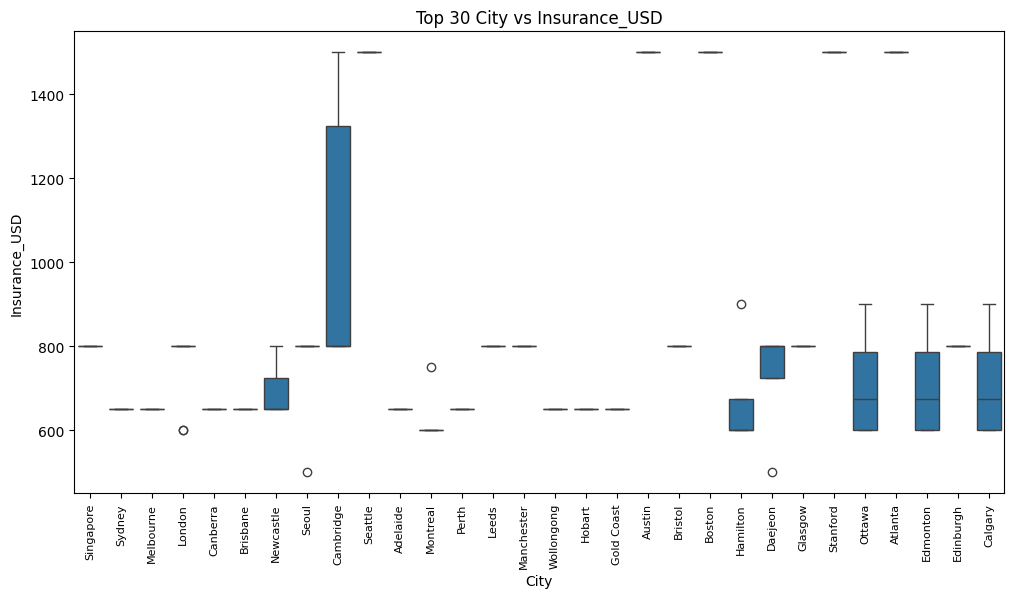

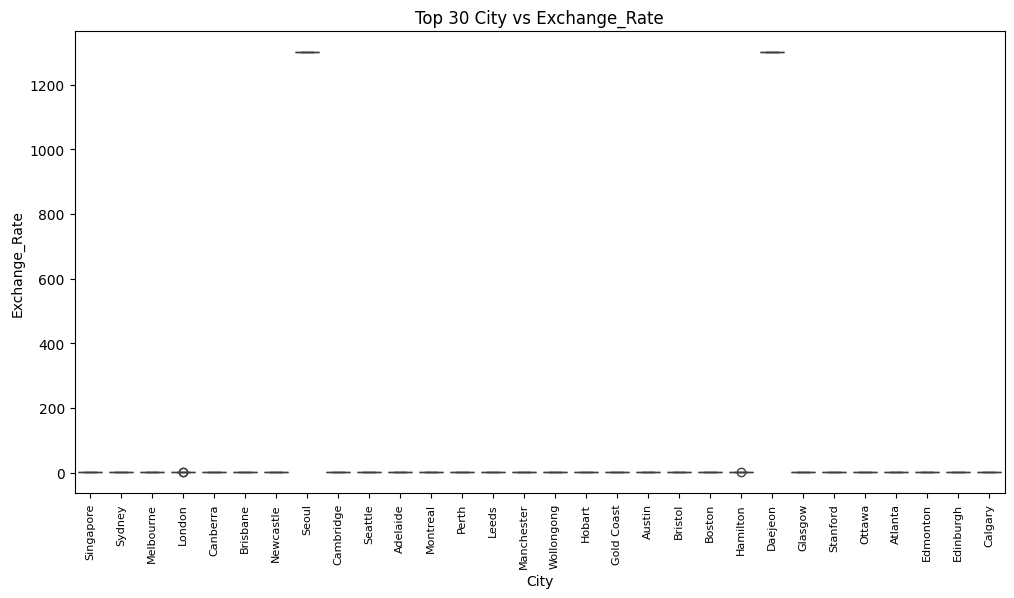


Value counts for University:
University
University of Washington           6
Stanford University                5
Australian National University     5
University of Tasmania             5
University of Western Australia    5
                                  ..
USM                                1
Universidad Politecnica            1
Imperial College                   1
ITCA-FEPADE                        1
Andijan State University           1
Name: count, Length: 622, dtype: int64


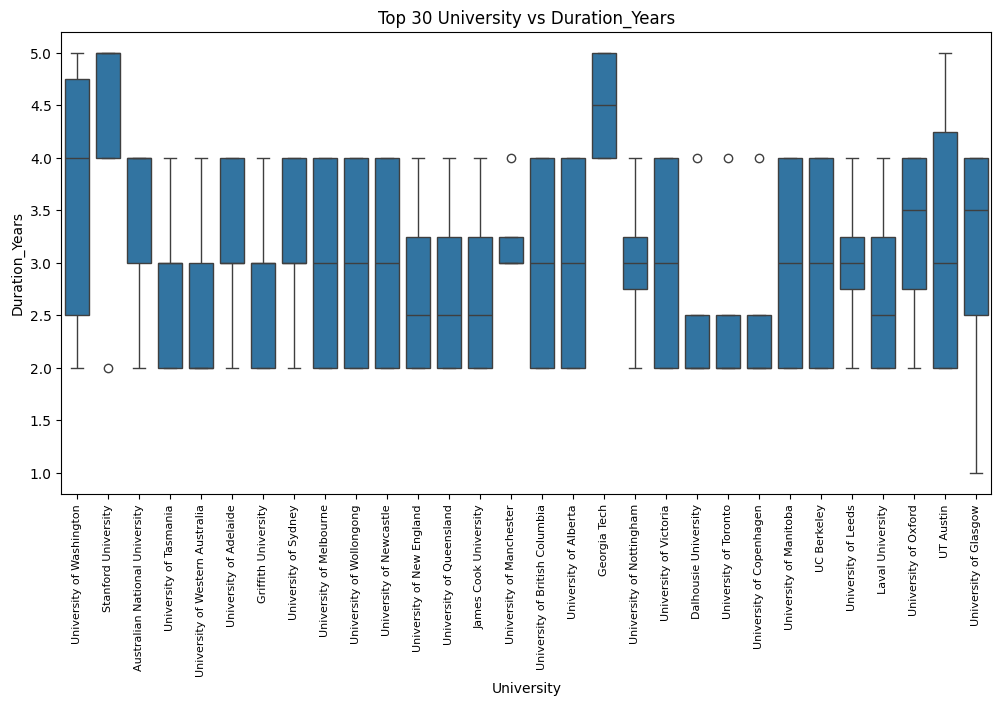

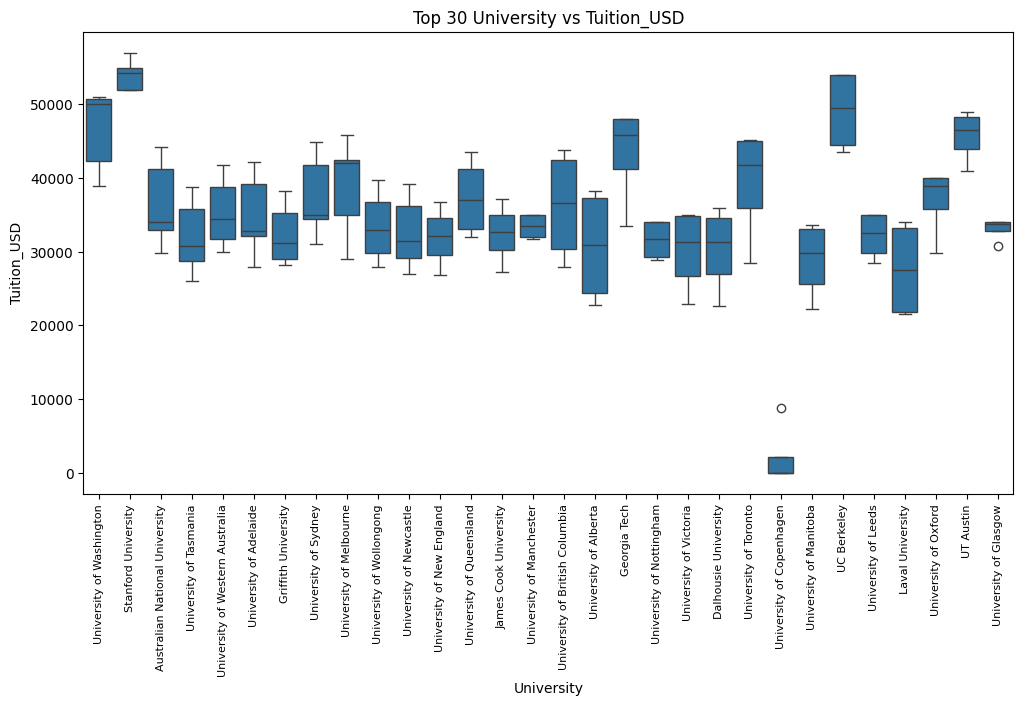

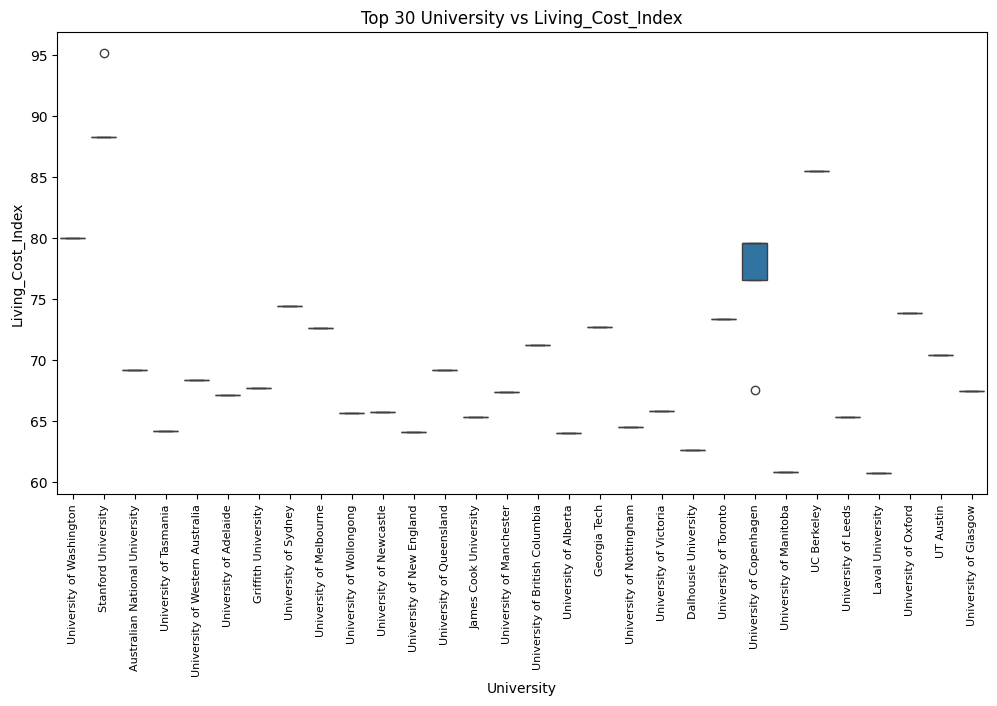

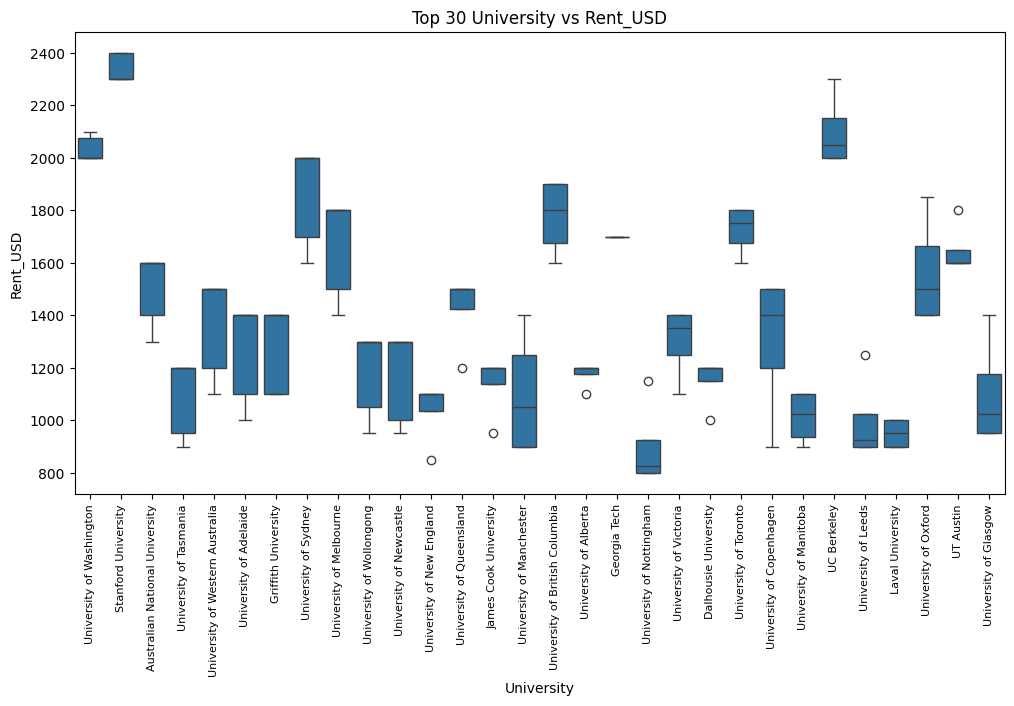

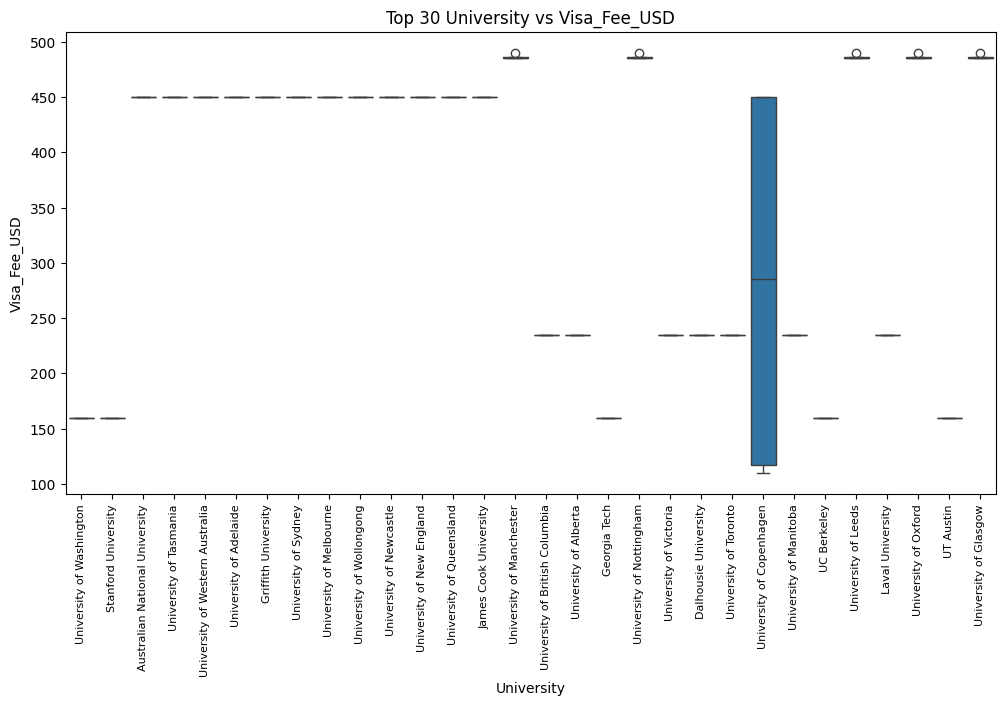

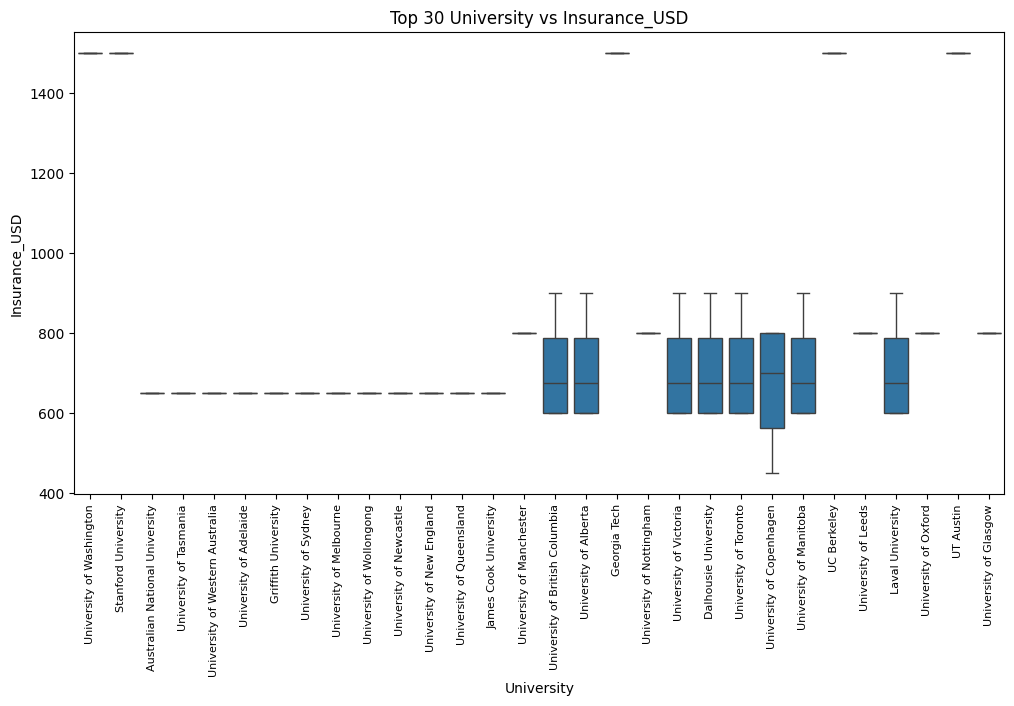

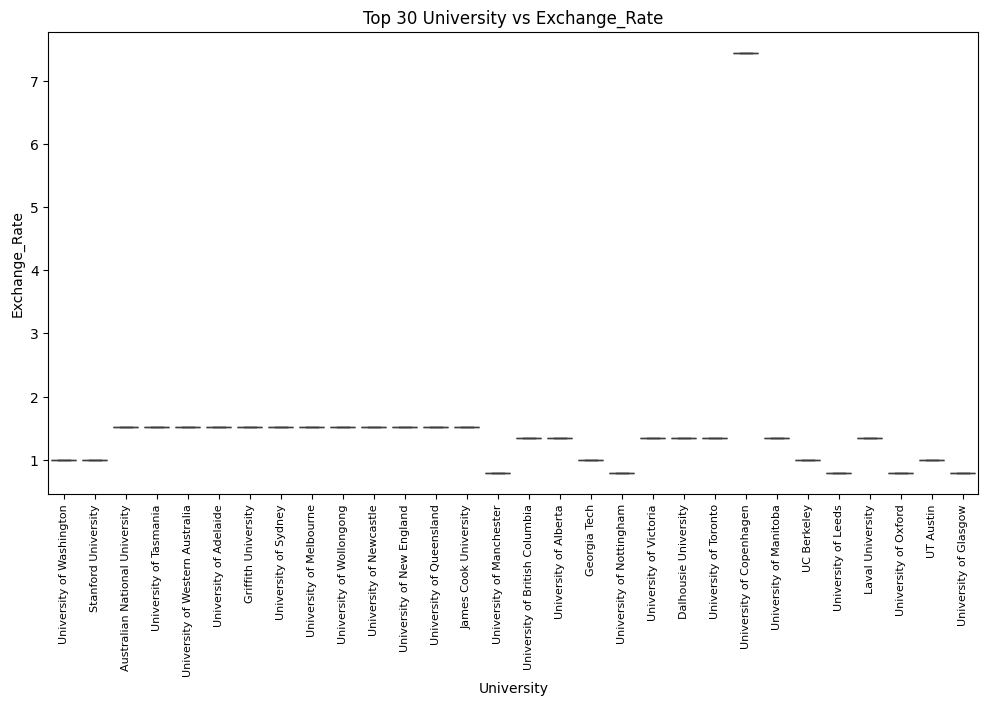


Value counts for Program:
Program
Computer Science           312
Data Science                82
Computer Engineering        71
Software Engineering        57
Artificial Intelligence     53
                          ... 
Electronics                  1
Electronic Engineering       1
Digital Design               1
Digital Business             1
Data Systems                 1
Name: count, Length: 92, dtype: int64


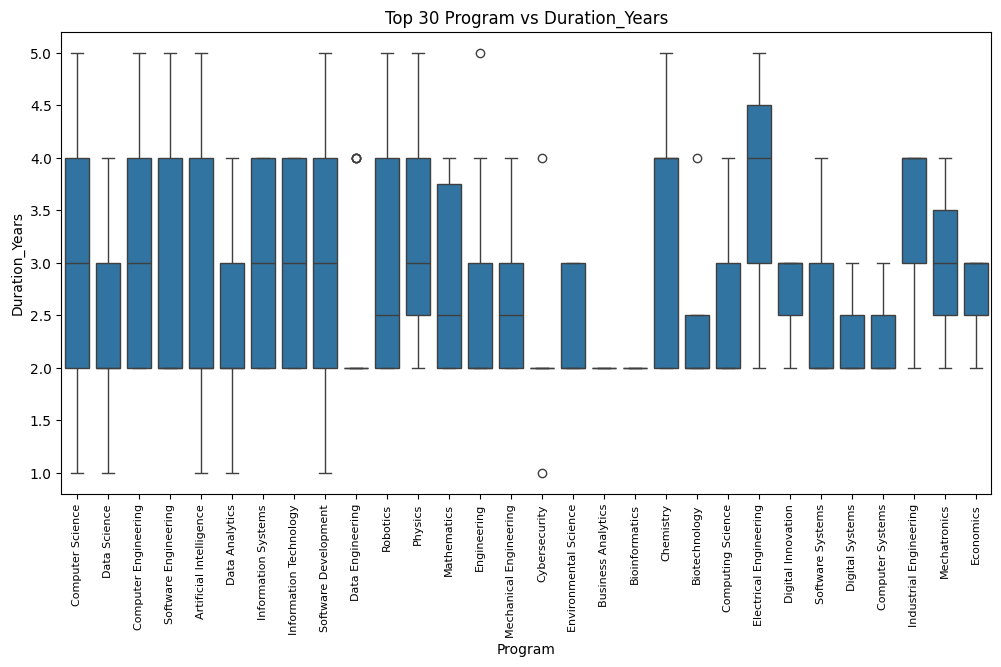

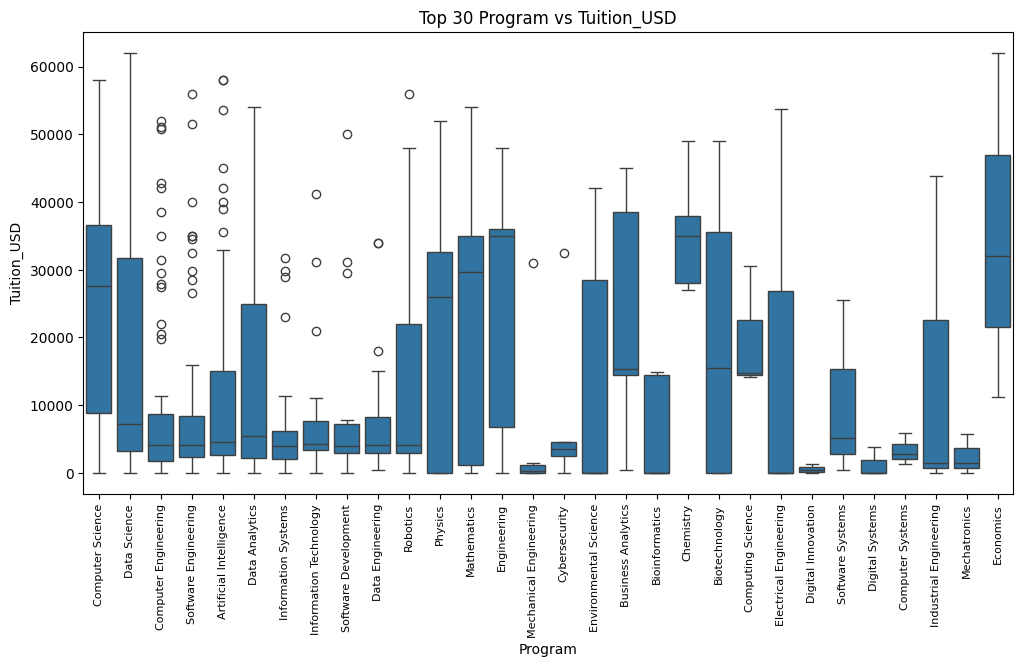

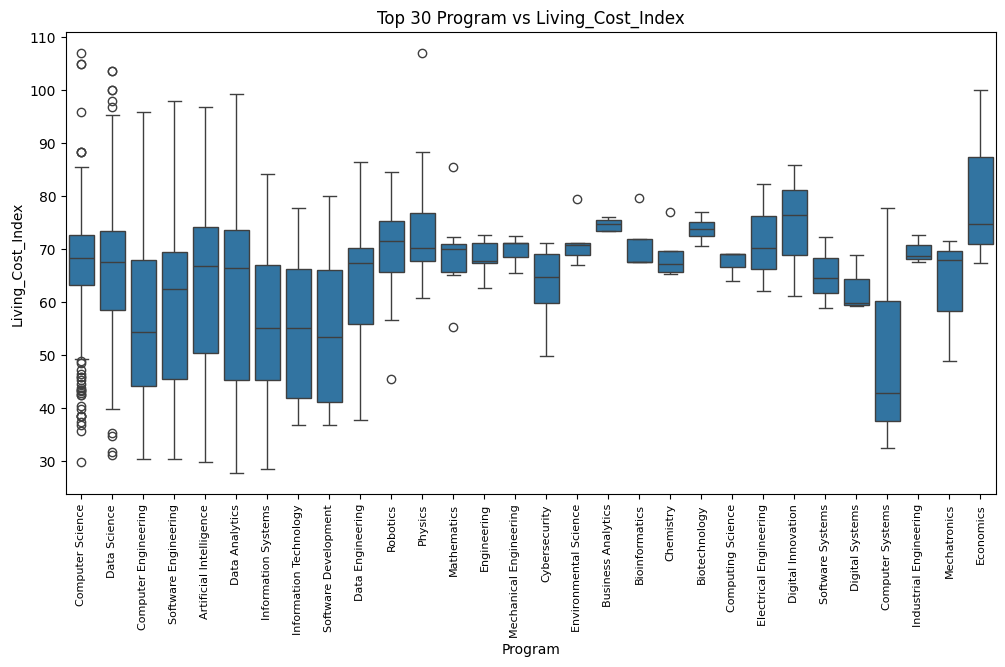

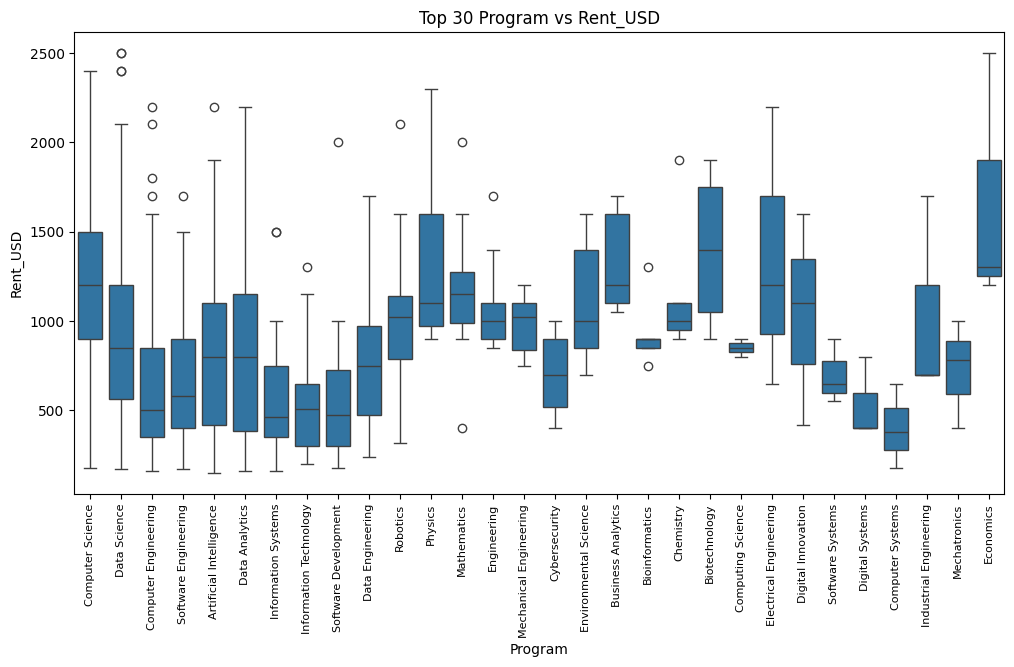

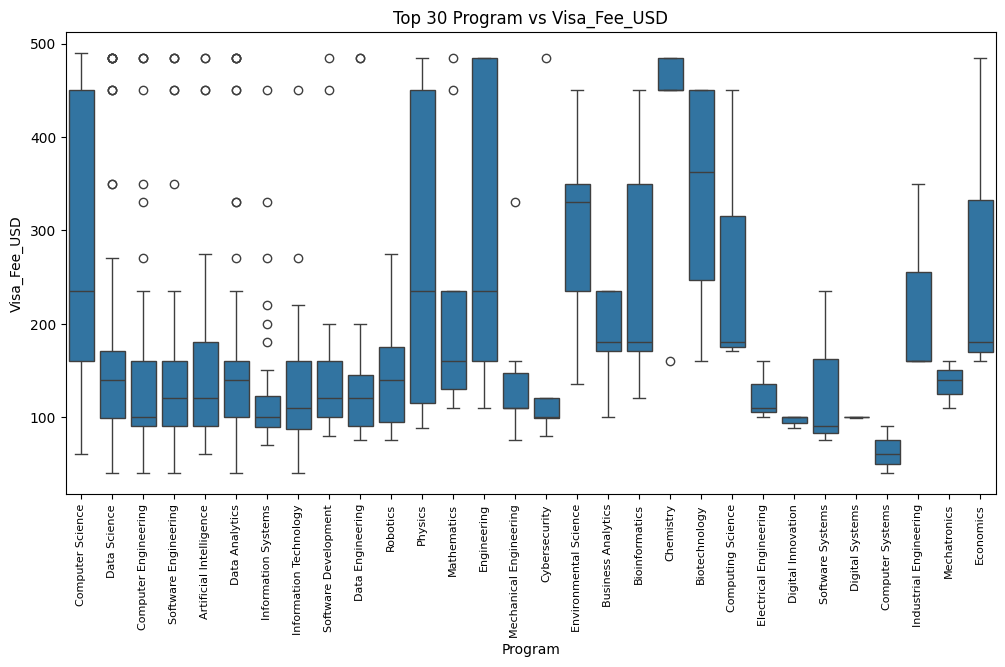

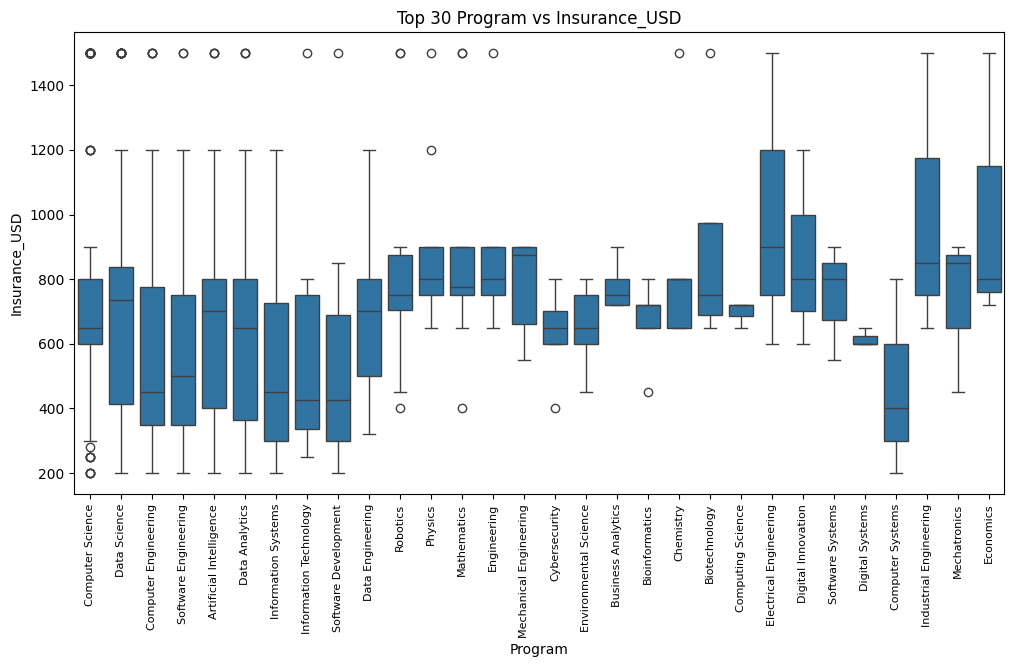

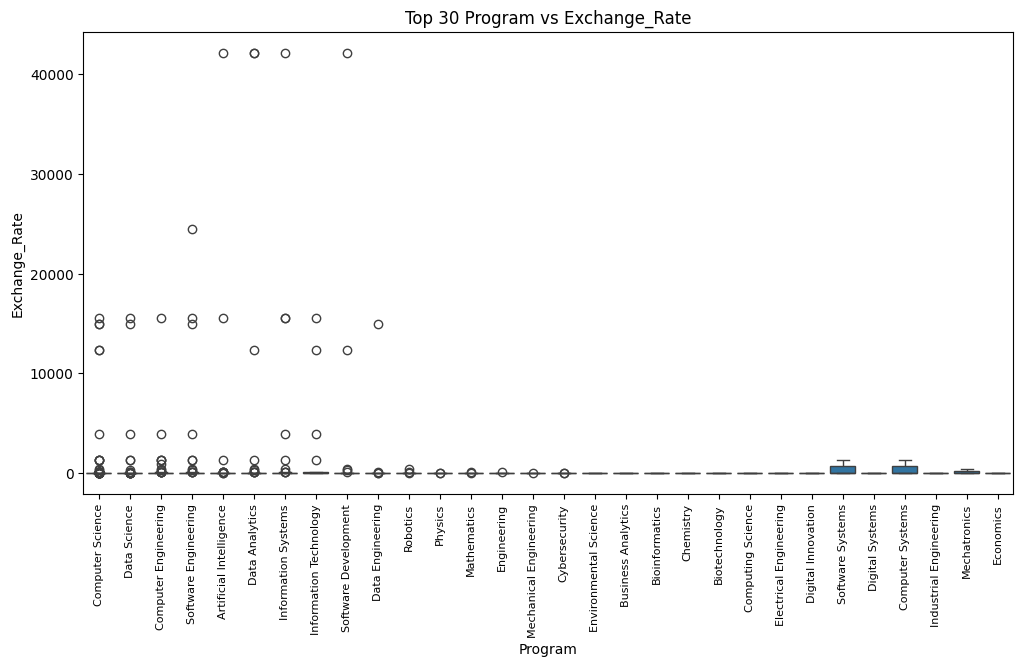


Value counts for Level:
Level
Master      451
Bachelor    297
PhD         159
Name: count, dtype: int64


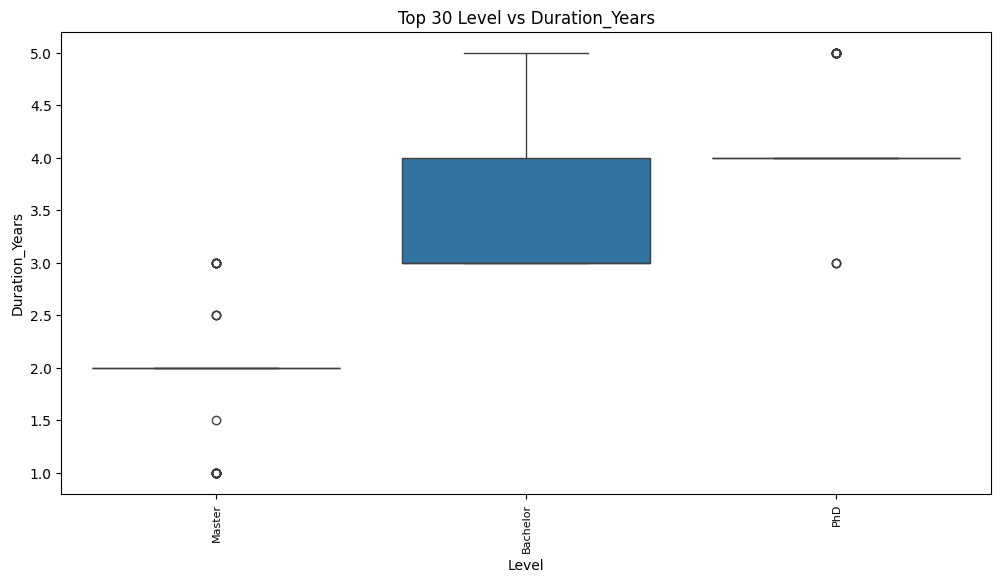

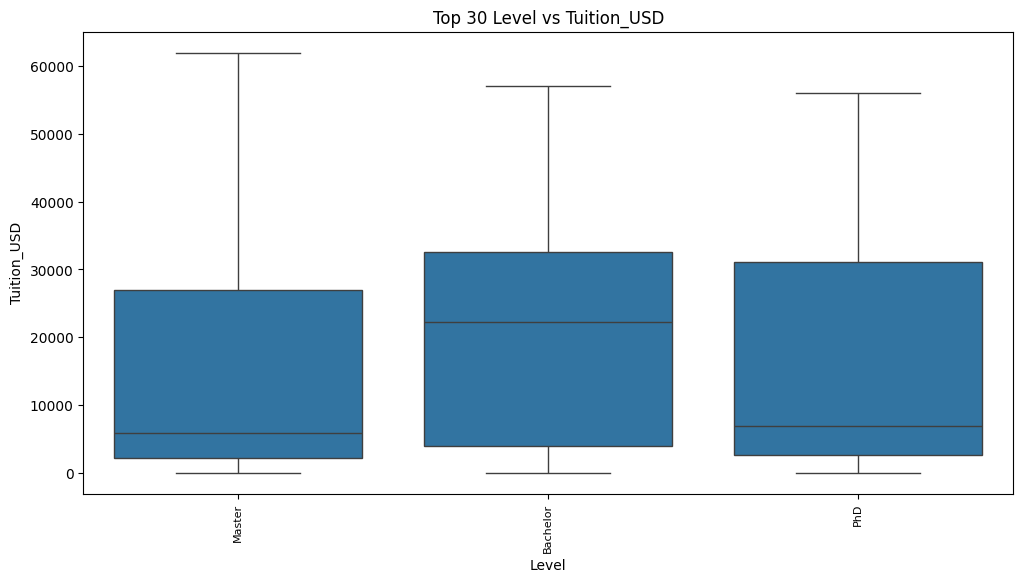

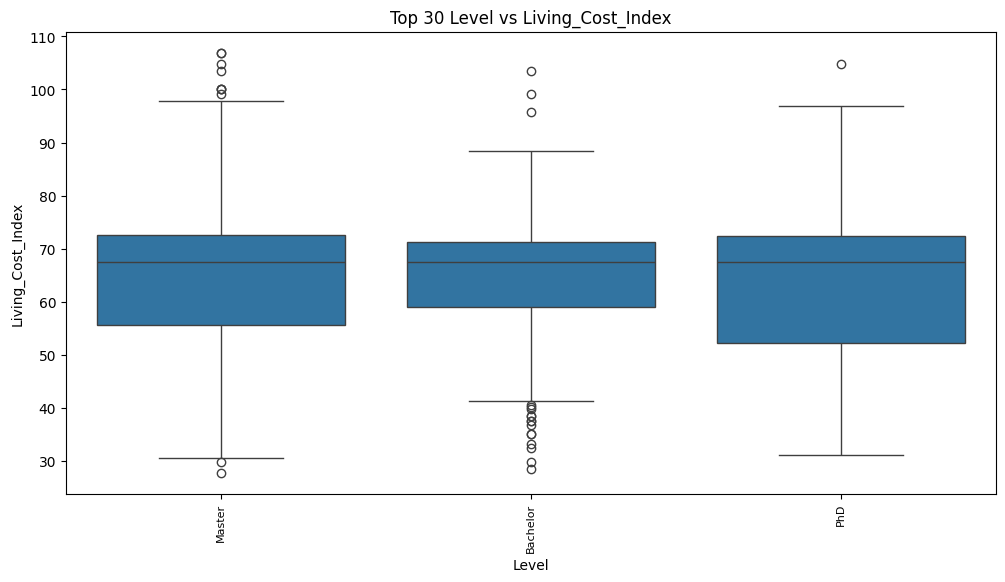

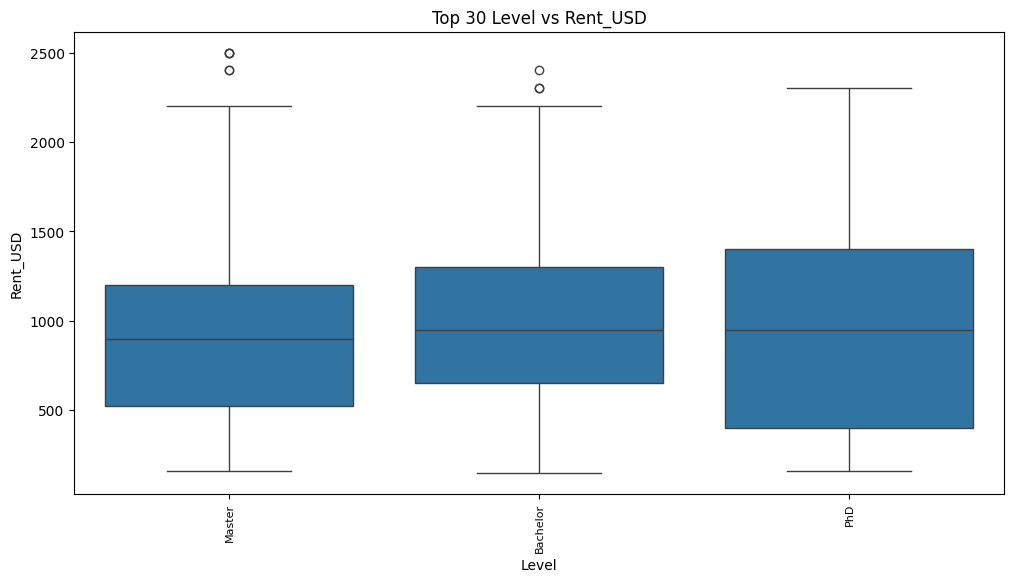

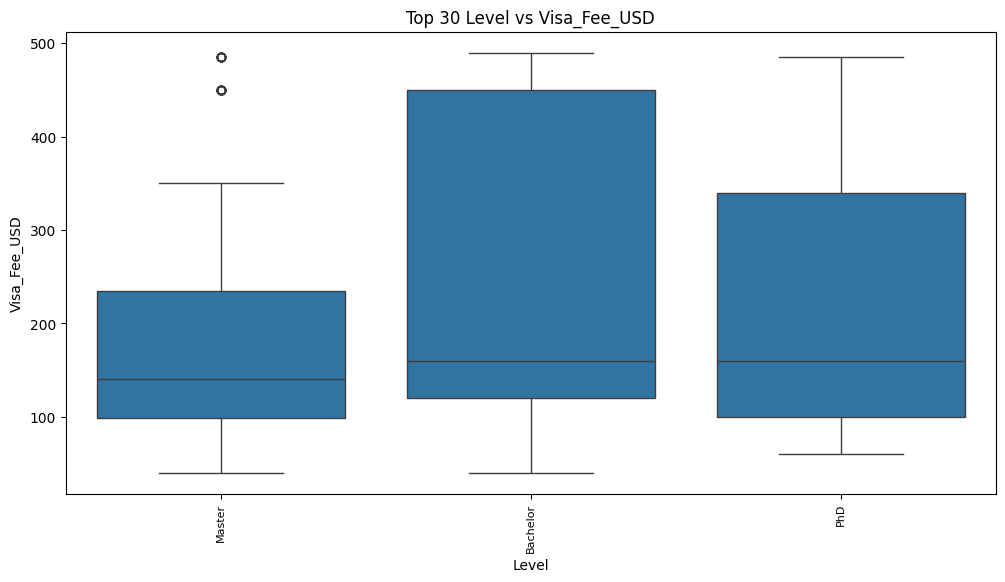

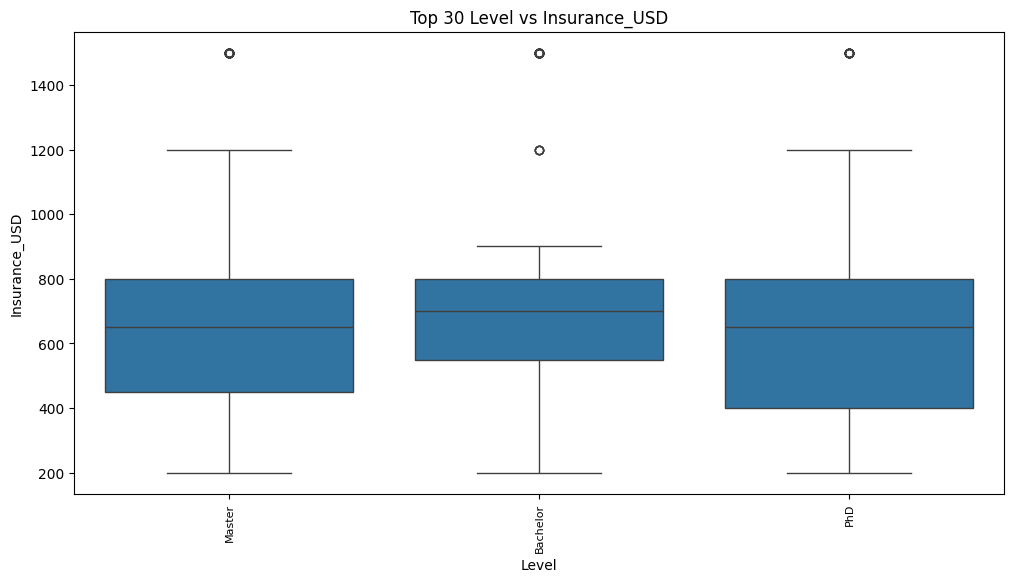

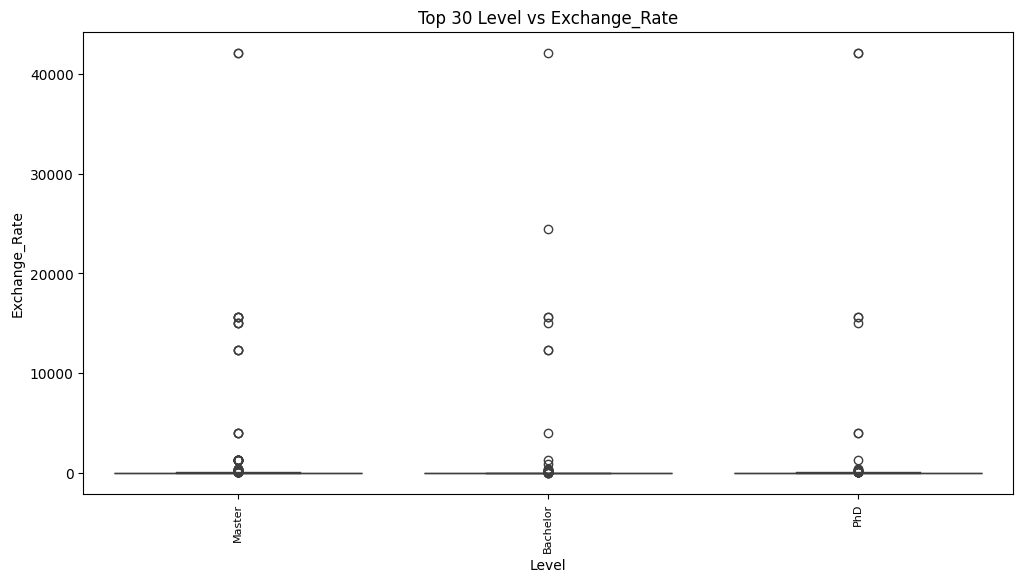

In [36]:
# Box plots for categorical vs numerical variables
for cat_col in categorical_columns:
    print(f"\nValue counts for {cat_col}:")
    value_counts = df[cat_col].value_counts().head(30)
    print(df[cat_col].value_counts())
    for num_col in numerical_columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=df, x=cat_col, y=num_col, order=value_counts.index)
        plt.xticks(rotation=90, fontsize=8)
        plt.title(f'Top 30 {cat_col} vs {num_col}')
        plt.show()



Feature Engineering (TCA = Total Cost of Attendance)

In [37]:
# tuition + visa + (rent × months x years) + (insurance × years)
# tuition is total program, visa is one time, rent is monthly, insurance is yearly
df['TCA'] = df['Tuition_USD'] + df['Visa_Fee_USD'] + (df['Rent_USD'] * 12 * df['Duration_Years']) + (df['Insurance_USD'] * df['Duration_Years'])


Key Insights and Summary

In [38]:
# Summary statistics by groups
for cat_col in categorical_columns:
    print(f"\nSummary statistics by {cat_col}:")
    print(df.groupby(cat_col)[numerical_columns].agg(['mean', 'std', 'min', 'max']).round(1))

# Calculate key metrics
print("\nKey Metrics:")
print("Average TCA by country:", df.groupby('Country')['TCA'].mean().round(1).sort_values(ascending=False))
print("TCA range by program type:", df.groupby('Program')['TCA'].agg(['min', 'max', 'mean']).round(1))


Summary statistics by Country:
           Duration_Years                Tuition_USD                        \
                     mean  std  min  max        mean     std    min    max   
Country                                                                      
Algeria               2.8  0.8  2.0  4.0      1100.0   158.1    900   1300   
Argentina             3.5  1.2  2.0  5.0         0.0     0.0      0      0   
Australia             3.0  0.8  2.0  4.0     34610.5  5231.0  25200  45800   
Austria               2.7  0.7  2.0  4.0      1500.0     0.0   1500   1500   
Bahrain               3.2  1.1  2.0  4.0      7600.0   961.8   6500   9000   
...                   ...  ...  ...  ...         ...     ...    ...    ...   
USA                   3.4  1.2  2.0  5.0     47742.3  8454.1  26500  62000   
Ukraine               2.8  1.1  2.0  4.0      3520.0   192.4   3300   3800   
Uruguay               2.8  1.1  2.0  4.0      2700.0  3701.4      0   7000   
Uzbekistan            2.8  1.1  

Data Visualization Dashboard

In [39]:
# Create a dashboard using plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Interactive scatter plot
fig = px.scatter(df, x='TCA', y='Duration_Years', color='Country',
                 title='Cost vs Duration by Country',
                 hover_data=['Program'])
fig.show()

# Interactive box plot
fig = px.box(df, x='Country', y='TCA',
             title='Cost Distribution by Country')
fig.show()

In [40]:
print(df['TCA'].describe().round(1))

count       907.0
mean      52218.1
std       37459.2
min        5700.0
25%       22644.5
50%       40020.0
75%       75600.0
max      199860.0
Name: TCA, dtype: float64


Total Cost of Attendance Visual Output

In [41]:
# Set the style for better visualization
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (15, 10)

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
fig.suptitle('TCA Averages by Different Categories', fontsize=16, y=1.02)

# 1. TCA by Level
level_avg = df.groupby('Level')['TCA'].mean().sort_values(ascending=False)
sns.barplot(x=level_avg.index, y=level_avg.values, ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Average TCA by Education Level')
axes[0, 0].set_xlabel('Education Level')
axes[0, 0].set_ylabel('Average TCA (USD)')
axes[0, 0].tick_params(axis='x', rotation=90)

# 2. TCA by Country (Top 30)
country_avg = df.groupby('Country')['TCA'].mean().sort_values(ascending=False).head(30)
sns.barplot(x=country_avg.index, y=country_avg.values, ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Top 30 Countries by Average TCA')
axes[0, 1].set_xlabel('Country')
axes[0, 1].set_ylabel('Average TCA (USD)')
axes[0, 1].tick_params(axis='x', rotation=90)

# 3. TCA by City (Top 30)
city_avg = df.groupby('City')['TCA'].mean().sort_values(ascending=False).head(30)
sns.barplot(x=city_avg.index, y=city_avg.values, ax=axes[1, 0], palette='magma')
axes[1, 0].set_title('Top 30 Cities by Average TCA')
axes[1, 0].set_xlabel('City')
axes[1, 0].set_ylabel('Average TCA (USD)')
axes[1, 0].tick_params(axis='x', rotation=90)

# 4. TCA by Program (Top 30)
program_avg = df.groupby('Program')['TCA'].mean().sort_values(ascending=False).head(30)
sns.barplot(x=program_avg.index, y=program_avg.values, ax=axes[1, 1], palette='cividis')
axes[1, 1].set_title('Top 30 Programs by Average TCA')
axes[1, 1].set_xlabel('Program')
axes[1, 1].set_ylabel('Average TCA (USD)')
axes[1, 1].tick_params(axis='x', rotation=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Save the plot
plt.savefig('TCA_analysis.png', bbox_inches='tight', dpi=300)
plt.close()

In [42]:
# Print summary statistics
print("\nTCA Analysis Summary:")
print("\nAverage TCA by Level:")
print(level_avg.round(1))
print("\nTop 30 Countries by Average TCA:")
print(country_avg.round(1))
print("\nTop 30 Cities by Average TCA:")
print(city_avg.round(1))
print("\nTop 30 Programs by Average TCA:")
print(program_avg.round(1)) 



TCA Analysis Summary:

Average TCA by Level:
Level
PhD         69115.4
Bachelor    64526.5
Master      38155.5
Name: TCA, dtype: float64

Top 30 Countries by Average TCA:
Country
USA               127748.5
Hong Kong          96520.0
Singapore          89517.8
Australia          85741.3
Canada             73643.6
UK                 73049.0
New Zealand        62987.2
UAE                59182.5
Ireland            58805.0
Israel             57750.0
Switzerland        53408.8
Netherlands        45917.5
Taiwan             40740.0
France             36950.9
Italy              36317.1
Japan              36282.5
Kuwait             35936.0
Denmark            35621.3
Belgium            34761.1
Luxembourg         34557.1
Czech Republic     34500.0
Bahrain            33986.0
Norway             33339.5
Spain              32322.9
Lebanon            31062.0
Sweden             30838.0
Iceland            30340.0
Germany            30161.4
Saudi Arabia       29971.0
Austria            29143.3
Name: TCA,

Remove TCA outliers and export for modeling

In [43]:
# Detect outliers using IQR method

Q1 = df['TCA'].quantile(0.25)
Q3 = df['TCA'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
    
print(f"Initial number of rows: {len(df)}")


# Keep rows within TCA outliers
df_cleaned = df[(df['TCA'] >= lower_bound) & (df['TCA'] <= upper_bound)]

# Print final number of rows and number of rows removed
print(f"\nFinal number of rows: {len(df_cleaned)}")
print(f"Number of rows removed: {len(df) - len(df_cleaned)}")

# Remove columns used in TCA calculation to avoid overfitting in future models
columns_to_remove = ['Tuition_USD', 'Visa_Fee_USD', 'Rent_USD', 'Insurance_USD', 'Duration_Years']
df_cleaned = df_cleaned.drop(columns=columns_to_remove, errors='ignore')

# Export the cleaned dataset
data_dir = '../data'
output_file = os.path.join(data_dir, 'TCA_no_outliers.csv')
df_cleaned.to_csv(output_file, index=False)
print(f"\nCleaned dataset exported to: {output_file}")


Initial number of rows: 907

Final number of rows: 889
Number of rows removed: 18

Cleaned dataset exported to: ../data\TCA_no_outliers.csv

Cleaned dataset exported to: ../data\TCA_no_outliers.csv
